In [1]:
from sys import path
path.append('../src/')

import os
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import pickle as pkl
import random as rn
import tensorflow as tf

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, GlobalAvgPool2D
from keras.models import Model, load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight

from global_config import FILE_DUMP_IMAGES, FILE_DUMP_MRKS, FOLDER_MODELS 
from global_config import RANDOM_SEED, IMAGE_SIZE, USER_IDS
from utils import load, plot
from custom_losses import precision, recall, f1, specificity 
from custom_losses import negative_predictive_value as npv 
from custom_losses import matthews_correlation_coefficient as mcc

%matplotlib inline

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
print(FILE_DUMP_IMAGES)
print(FILE_DUMP_MRKS)
print(FOLDER_MODELS)
print(IMAGE_SIZE)
print(RANDOM_SEED)
print(USER_IDS)

../data/pybossa/pybossa_images.pkl
../data/pybossa/pybossa_mrks.pkl
../models/autoencoders_requirements/
(224, 224)
42
1_2_5


In [3]:
TEST_SIZE = 0.2

MLFLOW_EXPERIMENT_NAME = 'Autoencoder Requirements'

FILE_BASE_MODEL = '../models/autoencoders_unsupervised/model_2020_03_15-10_43_27.h5'
FILE_MERGED_MODEL = f'{FOLDER_MODELS}merged_model_{USER_IDS}.h5'

In [4]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'

def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)
    
def plot_metrics(y_true, y_pred, hist):
    conf_matrix = confusion_matrix(y_true, y_pred) 
    tn, fp, fn, tp = conf_matrix.ravel()
    
    accuracy_sk = accuracy_score(y_true, y_pred)
    precision_sk = precision_score(y_true, y_pred)
    recall_sk = recall_score(y_true, y_pred)
    f_measure = f1_score(y_true, y_pred)
    specificity_sk = tn / (tn + fp + 1e-7)
    npv_sk = tn / (tn + fn + 1e-7)
    
    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    mcc_sk = num / np.sqrt(den + 1e-7)
    
    print()
    print('   Final Accuracy: {:=6.2f}%'.format(accuracy_sk * 100))
    print('  Final Precision: {:=6.2f}%'.format(precision_sk * 100))
    print('     Final Recall: {:=6.2f}%'.format(recall_sk * 100))
    print('  Final F-measure: {:=6.2f}%'.format(f_measure * 100))
    print('Final Specificity: {:=6.2f}%'.format(specificity_sk * 100))
    print('        Final NPV: {:=6.2f}%'.format(npv_sk * 100))
    print('        Final MCC: {:=6.2f}%'.format(mcc_sk * 100))    

    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    plot.keras_hist(hist.history)

In [5]:
def build_model(base_model, name):
    set_random_seeds()

    outputs = Dense(units=64, activation='relu', name=f'{name}_1')(base_model.output)
    outputs = Dense(units=32, activation='relu', name=f'{name}_2')(outputs)
    outputs = Dense(units=1, activation='sigmoid', name=f'{name}')(outputs)
    model = Model(inputs=base_model.inputs, outputs=outputs)

    for layer in model.layers:
        layer.trainable = (name in layer.name)

    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy', precision, recall, f1, specificity, npv, mcc]
    )
    return model


def train_model(model, x_train, y_train, x_val, y_val, name):
    FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix=f'{name}_')
    metric_to_monitor = 'val_matthews_correlation_coefficient'
    
    list_callbacks = [
        EarlyStopping(monitor=metric_to_monitor, mode='max', patience=30, verbose=1, restore_best_weights=True),
        ModelCheckpoint(FILE_MODEL, monitor=metric_to_monitor, mode='max', verbose=1, save_best_only=True)
    ]
    
    classes = np.unique(y_train)
    weights = compute_class_weight('balanced', classes, y_train)
    class_weights = dict(zip(classes, weights))
    u_train, c_train = np.unique(y_train, return_counts=True)
    u_val, c_val = np.unique(y_val, return_counts=True)
    
    mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
    mlflow.log_param("test_size", TEST_SIZE)
    mlflow.log_param("seed", RANDOM_SEED)
    mlflow.log_param("class_train", dict(zip(u_train, c_train)))
    mlflow.log_param("class_val", dict(zip(u_val, c_val)))
    mlflow.log_param("class_train_prop", dict(zip(u_train, c_train / c_train.sum())))
    mlflow.log_param("class_val_prop", dict(zip(u_val, c_val / c_val.sum())))
    mlflow.set_tag("requirement", name)
    mlflow.set_tag("user_ids", USER_IDS)
    mlflow.keras.autolog()

    hist = model.fit(
        x_train / 255, 
        y_train, 
        batch_size=32, 
        epochs=100, 
        validation_data=(x_val / 255, y_val),
        class_weight=class_weights,
        callbacks=list_callbacks
    )
    mlflow.end_run()
    
    return hist, FILE_MODEL


def train_requirement_branch(base_model, x, y, name):
    classes, counts = np.unique(y, return_counts=True) 
    if len(classes) == 1:
        print(f"the requirement {name} has only one label.")
        return None
    
    if min(counts) == 1:
        print(f"the requirement {name} has only one sample for one of the classes.")
        return None

    x_train, x_val, y_train, y_val = train_test_split(
        x, y, 
        test_size=TEST_SIZE, 
        stratify=y, 
        random_state=RANDOM_SEED
    )

    model = build_model(base_model, name)
    hist, file_model = train_model(model, x_train, y_train, x_val, y_val, name)
    
    y_pred = model.predict(x_val / 255)
    y_pred = np.where(y_pred > 0.5, 1, 0)
    plot_metrics(y_val, y_pred, hist)

    return file_model

# Load Autoencoder 

In [6]:
model = load_model(FILE_BASE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(model.get_layer(name='encoded').output)

encoder = Model(inputs=model.inputs, outputs=embeddings)
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 224, 224, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 224, 224, 16)      64        
_________________________________________________________________
relu_1 (Activation)          (None, 224, 224, 16)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 112, 112, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 112, 112, 32)      4640      
_________________________________________________________________
bn_2 (Batch

# Requirements Training

In [7]:
x, _ = pkl.load(open(FILE_DUMP_IMAGES, 'rb'))
mrks, _ = pkl.load(open(FILE_DUMP_MRKS, 'rb'))

print(x.shape, x.dtype)
print(mrks.shape, mrks.dtype)

list_model_files = []

(5763, 224, 224, 3) float32
(5763,) object


#### 2. Blurred

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 12s 2ms/step - loss: 0.5412 - accuracy: 0.6670 - precision: 0.9519 - recall: 0.6589 - f1: 0.7675 - specificity: 0.7595 - negative_predictive_value: 0.2322 - matthews_correlation_coefficient: 0.2745 - val_loss: 0.5849 - val_accuracy: 0.6149 - val_precision: 0.9494 - val_recall: 0.5651 - val_f1: 0.7041 - val_specificity: 0.8500 - val_negative_predictive_value: 0.2289 - val_matthews_correlation_coefficient: 0.2688

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.26885, saving model to ../models/autoencoders_requirements/blurred_2020_03_28-19_26_00.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5094 - accuracy: 0.6358 - precision: 0.9683 - recall: 0.6117 - f1: 0.7417 - specificity: 0.8047 - negative_predictive_value: 0.2200 - matthews_correlation_coefficient: 0.2792 - val_loss: 0.4687 - val_accuracy: 0.7615 - val_precision: 0.


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.38438
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4148 - accuracy: 0.7440 - precision: 0.9803 - recall: 0.7288 - f1: 0.8308 - specificity: 0.8712 - negative_predictive_value: 0.3071 - matthews_correlation_coefficient: 0.4049 - val_loss: 0.4990 - val_accuracy: 0.7372 - val_precision: 0.9491 - val_recall: 0.7013 - val_f1: 0.8023 - val_specificity: 0.8244 - val_negative_predictive_value: 0.3029 - val_matthews_correlation_coefficient: 0.3581

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.38438
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4123 - accuracy: 0.7343 - precision: 0.9797 - recall: 0.7197 - f1: 0.8241 - specificity: 0.8628 - negative_predictive_value: 0.2879 - matthews_correlation_coefficient: 0.3862 - val_loss: 0.4418 - val_accuracy: 0.7771 - val_precision: 0.9357 - val_recall: 0.7591 - val_f1: 0.8351 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3736 - accuracy: 0.7751 - precision: 0.9830 - recall: 0.7593 - f1: 0.8532 - specificity: 0.8641 - negative_predictive_value: 0.3226 - matthews_correlation_coefficient: 0.4286 - val_loss: 0.3882 - val_accuracy: 0.8075 - val_precision: 0.9421 - val_recall: 0.7873 - val_f1: 0.8554 - val_specificity: 0.7393 - val_negative_predictive_value: 0.3532 - val_matthews_correlation_coefficient: 0.3902

Epoch 00029: val_matthews_correlation_coefficient improved from 0.38887 to 0.39018, saving model to ../models/autoencoders_requirements/blurred_2020_03_28-19_26_00.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3754 - accuracy: 0.7809 - precision: 0.9779 - recall: 0.7704 - f1: 0.8576 - specificity: 0.8522 - negative_predictive_value: 0.3258 - matthews_correlation_coefficient: 0.4314 - val_loss: 0.4779 - val_accuracy: 0.7658 - val_precision: 0.9453 - val_recall: 0.7378 - val_f1: 0.8257 - val_specific

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3636 - accuracy: 0.7866 - precision: 0.9822 - recall: 0.7748 - f1: 0.8630 - specificity: 0.8538 - negative_predictive_value: 0.3353 - matthews_correlation_coefficient: 0.4418 - val_loss: 0.5324 - val_accuracy: 0.7320 - val_precision: 0.9551 - val_recall: 0.6906 - val_f1: 0.7974 - val_specificity: 0.8695 - val_negative_predictive_value: 0.3049 - val_matthews_correlation_coefficient: 0.3771

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.39821
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3701 - accuracy: 0.7816 - precision: 0.9831 - recall: 0.7688 - f1: 0.8588 - specificity: 0.8640 - negative_predictive_value: 0.3371 - matthews_correlation_coefficient: 0.4424 - val_loss: 0.3116 - val_accuracy: 0.8656 - val_precision: 0.9217 - val_recall: 0.8749 - val_f1: 0.8967 - val_specificity: 0.5483 - val_negative_predictive_value: 0.4060 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3476 - accuracy: 0.8059 - precision: 0.9845 - recall: 0.7957 - f1: 0.8767 - specificity: 0.8791 - negative_predictive_value: 0.3698 - matthews_correlation_coefficient: 0.4784 - val_loss: 0.4519 - val_accuracy: 0.7710 - val_precision: 0.9516 - val_recall: 0.7376 - val_f1: 0.8281 - val_specificity: 0.8103 - val_negative_predictive_value: 0.3267 - val_matthews_correlation_coefficient: 0.3862

Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.42526
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3578 - accuracy: 0.7937 - precision: 0.9802 - recall: 0.7830 - f1: 0.8654 - specificity: 0.8461 - negative_predictive_value: 0.3423 - matthews_correlation_coefficient: 0.4466 - val_loss: 0.3748 - val_accuracy: 0.8239 - val_precision: 0.9376 - val_recall: 0.8105 - val_f1: 0.8678 - val_specificity: 0.7029 - val_negative_predictive_value: 0.3772 - val_matthews_correlation_coefficie


Epoch 00071: val_matthews_correlation_coefficient did not improve from 0.43759
Epoch 72/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3367 - accuracy: 0.8137 - precision: 0.9844 - recall: 0.8039 - f1: 0.8833 - specificity: 0.8517 - negative_predictive_value: 0.3581 - matthews_correlation_coefficient: 0.4681 - val_loss: 0.3599 - val_accuracy: 0.8239 - val_precision: 0.9401 - val_recall: 0.8084 - val_f1: 0.8670 - val_specificity: 0.7225 - val_negative_predictive_value: 0.3792 - val_matthews_correlation_coefficient: 0.4050

Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.43759
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3416 - accuracy: 0.8080 - precision: 0.9850 - recall: 0.7941 - f1: 0.8770 - specificity: 0.8844 - negative_predictive_value: 0.3624 - matthews_correlation_coefficient: 0.4797 - val_loss: 0.4013 - val_accuracy: 0.8005 - val_precision: 0.9458 - val_recall: 0.7756 - val_f1: 0.8493 - val_spe


Epoch 00086: val_matthews_correlation_coefficient did not improve from 0.44064
Epoch 87/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3264 - accuracy: 0.8187 - precision: 0.9824 - recall: 0.8096 - f1: 0.8837 - specificity: 0.8945 - negative_predictive_value: 0.3855 - matthews_correlation_coefficient: 0.5018 - val_loss: 0.3552 - val_accuracy: 0.8352 - val_precision: 0.9421 - val_recall: 0.8201 - val_f1: 0.8750 - val_specificity: 0.7248 - val_negative_predictive_value: 0.3826 - val_matthews_correlation_coefficient: 0.4139

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.44064
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3519 - accuracy: 0.8074 - precision: 0.9851 - recall: 0.7972 - f1: 0.8779 - specificity: 0.8719 - negative_predictive_value: 0.3637 - matthews_correlation_coefficient: 0.4747 - val_loss: 0.3702 - val_accuracy: 0.8378 - val_precision: 0.9362 - val_recall: 0.8287 - val_f1: 0.8775 - val_spe

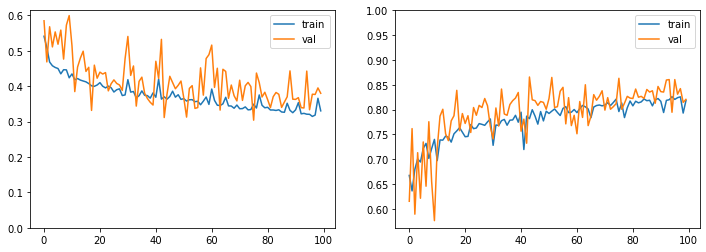

In [8]:
y = np.array([mrk.photo_reqs.blurred.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'blurred')
list_model_files.append(model_file)

#### 3. Looking Away

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6707 - accuracy: 0.5935 - precision: 0.7602 - recall: 0.5871 - f1: 0.6441 - specificity: 0.6028 - negative_predictive_value: 0.4223 - matthews_correlation_coefficient: 0.1869 - val_loss: 0.6870 - val_accuracy: 0.5577 - val_precision: 0.7538 - val_recall: 0.4788 - val_f1: 0.5774 - val_specificity: 0.7091 - val_negative_predictive_value: 0.4159 - val_matthews_correlation_coefficient: 0.1778

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.17781, saving model to ../models/autoencoders_requirements/looking_away_2020_03_28-19_40_52.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6590 - accuracy: 0.6206 - precision: 0.7625 - recall: 0.6266 - f1: 0.6762 - specificity: 0.6054 - negative_predictive_value: 0.4487 - matthews_correlation_coefficient: 0.2204 - val_loss: 0.7221 - val_accuracy: 0.5091 - val_precision


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.32516
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6172 - accuracy: 0.6716 - precision: 0.7977 - recall: 0.6896 - f1: 0.7305 - specificity: 0.6368 - negative_predictive_value: 0.5029 - matthews_correlation_coefficient: 0.3138 - val_loss: 0.6044 - val_accuracy: 0.6895 - val_precision: 0.7178 - val_recall: 0.8179 - val_f1: 0.7606 - val_specificity: 0.3749 - val_negative_predictive_value: 0.5127 - val_matthews_correlation_coefficient: 0.2358

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.32516
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6177 - accuracy: 0.6766 - precision: 0.7968 - recall: 0.7032 - f1: 0.7384 - specificity: 0.6219 - negative_predictive_value: 0.5106 - matthews_correlation_coefficient: 0.3148 - val_loss: 0.6031 - val_accuracy: 0.6843 - val_precision: 0.7599 - val_recall: 0.7251 - val_f1: 0.7376 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5815 - accuracy: 0.7024 - precision: 0.8212 - recall: 0.7241 - f1: 0.7613 - specificity: 0.6672 - negative_predictive_value: 0.5502 - matthews_correlation_coefficient: 0.3791 - val_loss: 0.6372 - val_accuracy: 0.6635 - val_precision: 0.7984 - val_recall: 0.6249 - val_f1: 0.6958 - val_specificity: 0.6850 - val_negative_predictive_value: 0.4714 - val_matthews_correlation_coefficient: 0.3153

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.33289
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5775 - accuracy: 0.7015 - precision: 0.8245 - recall: 0.7146 - f1: 0.7589 - specificity: 0.6855 - negative_predictive_value: 0.5433 - matthews_correlation_coefficient: 0.3825 - val_loss: 0.6272 - val_accuracy: 0.6592 - val_precision: 0.7993 - val_recall: 0.6136 - val_f1: 0.6898 - val_specificity: 0.6961 - val_negative_predictive_value: 0.4700 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.36218
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5642 - accuracy: 0.7143 - precision: 0.8360 - recall: 0.7215 - f1: 0.7679 - specificity: 0.7089 - negative_predictive_value: 0.5594 - matthews_correlation_coefficient: 0.4114 - val_loss: 0.6017 - val_accuracy: 0.6756 - val_precision: 0.8078 - val_recall: 0.6306 - val_f1: 0.7030 - val_specificity: 0.7123 - val_negative_predictive_value: 0.4888 - val_matthews_correlation_coefficient: 0.3450

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.36218
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5594 - accuracy: 0.7139 - precision: 0.8299 - recall: 0.7290 - f1: 0.7685 - specificity: 0.6900 - negative_predictive_value: 0.5644 - matthews_correlation_coefficient: 0.4049 - val_loss: 0.5902 - val_accuracy: 0.6817 - val_precision: 0.7856 - val_recall: 0.6779 - val_f1: 0.7226 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.36218
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5513 - accuracy: 0.7152 - precision: 0.8319 - recall: 0.7146 - f1: 0.7630 - specificity: 0.7074 - negative_predictive_value: 0.5479 - matthews_correlation_coefficient: 0.3989 - val_loss: 0.6368 - val_accuracy: 0.6271 - val_precision: 0.8220 - val_recall: 0.5319 - val_f1: 0.6406 - val_specificity: 0.7764 - val_negative_predictive_value: 0.4458 - val_matthews_correlation_coefficient: 0.3130

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.36218
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5583 - accuracy: 0.7098 - precision: 0.8404 - recall: 0.7090 - f1: 0.7606 - specificity: 0.7249 - negative_predictive_value: 0.5543 - matthews_correlation_coefficient: 0.4124 - val_loss: 0.6454 - val_accuracy: 0.6106 - val_precision: 0.7720 - val_recall: 0.5555 - val_f1: 0.6411 - val_spe

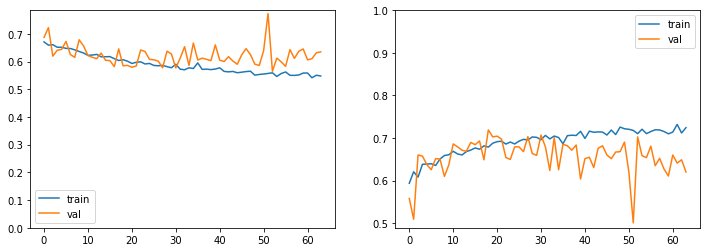

In [9]:
y = np.array([mrk.photo_reqs.looking_away.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'looking_away')
list_model_files.append(model_file)

#### 4. Ink Marked/Creased

In [10]:
y = np.array([mrk.photo_reqs.ink_marked_creased.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'ink_marked_creased')
list_model_files.append(model_file)

the requirement ink_marked_creased has only one label.


#### 5. Unnatural Skin Tone 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6259 - accuracy: 0.6544 - precision: 0.7589 - recall: 0.6759 - f1: 0.6926 - specificity: 0.6402 - negative_predictive_value: 0.5679 - matthews_correlation_coefficient: 0.3189 - val_loss: 0.5733 - val_accuracy: 0.6999 - val_precision: 0.7489 - val_recall: 0.7124 - val_f1: 0.7272 - val_specificity: 0.6565 - val_negative_predictive_value: 0.6053 - val_matthews_correlation_coefficient: 0.3611

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.36107, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_03_28-19_50_23.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5752 - accuracy: 0.7152 - precision: 0.7900 - recall: 0.7470 - f1: 0.7610 - specificity: 0.6755 - negative_predictive_value: 0.6253 - matthews_correlation_coefficient: 0.4179 - val_loss: 0.5493 - val_accuracy: 0.7398 - val_pr


Epoch 00014: val_matthews_correlation_coefficient improved from 0.51267 to 0.55100, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_03_28-19_50_23.h5
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4660 - accuracy: 0.7913 - precision: 0.8284 - recall: 0.8404 - f1: 0.8285 - specificity: 0.7098 - negative_predictive_value: 0.7346 - matthews_correlation_coefficient: 0.5573 - val_loss: 0.4645 - val_accuracy: 0.7910 - val_precision: 0.8054 - val_recall: 0.8141 - val_f1: 0.8063 - val_specificity: 0.7259 - val_negative_predictive_value: 0.7390 - val_matthews_correlation_coefficient: 0.5417

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.55100
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4760 - accuracy: 0.7870 - precision: 0.8260 - recall: 0.8424 - f1: 0.8286 - specificity: 0.7099 - negative_predictive_value: 0.7330 - matthews_correlation_coefficient: 0.5545 - val_loss: 0

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4374 - accuracy: 0.8115 - precision: 0.8442 - recall: 0.8573 - f1: 0.8460 - specificity: 0.7456 - negative_predictive_value: 0.7643 - matthews_correlation_coefficient: 0.6046 - val_loss: 0.4849 - val_accuracy: 0.7788 - val_precision: 0.8158 - val_recall: 0.7744 - val_f1: 0.7905 - val_specificity: 0.7576 - val_negative_predictive_value: 0.7069 - val_matthews_correlation_coefficient: 0.5269

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.57237
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4376 - accuracy: 0.8115 - precision: 0.8486 - recall: 0.8485 - f1: 0.8440 - specificity: 0.7465 - negative_predictive_value: 0.7539 - matthews_correlation_coefficient: 0.5996 - val_loss: 0.4307 - val_accuracy: 0.8049 - val_precision: 0.7951 - val_recall: 0.8574 - val_f1: 0.8223 - val_specificity: 0.6883 - val_negative_predictive_value: 0.7879 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.58537
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4101 - accuracy: 0.8249 - precision: 0.8457 - recall: 0.8652 - f1: 0.8526 - specificity: 0.7461 - negative_predictive_value: 0.7804 - matthews_correlation_coefficient: 0.6197 - val_loss: 0.4875 - val_accuracy: 0.7901 - val_precision: 0.8165 - val_recall: 0.7979 - val_f1: 0.8037 - val_specificity: 0.7478 - val_negative_predictive_value: 0.7230 - val_matthews_correlation_coefficient: 0.5421

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.58537
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4186 - accuracy: 0.8184 - precision: 0.8505 - recall: 0.8578 - f1: 0.8497 - specificity: 0.7546 - negative_predictive_value: 0.7635 - matthews_correlation_coefficient: 0.6140 - val_loss: 0.4602 - val_accuracy: 0.7875 - val_precision: 0.8244 - val_recall: 0.7774 - val_f1: 0.7966 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.58537
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4070 - accuracy: 0.8176 - precision: 0.8433 - recall: 0.8574 - f1: 0.8456 - specificity: 0.7470 - negative_predictive_value: 0.7619 - matthews_correlation_coefficient: 0.6105 - val_loss: 0.4354 - val_accuracy: 0.8057 - val_precision: 0.8168 - val_recall: 0.8293 - val_f1: 0.8191 - val_specificity: 0.7368 - val_negative_predictive_value: 0.7624 - val_matthews_correlation_coefficient: 0.5718

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.58537
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4130 - accuracy: 0.8182 - precision: 0.8517 - recall: 0.8616 - f1: 0.8531 - specificity: 0.7453 - negative_predictive_value: 0.7598 - matthews_correlation_coefficient: 0.6086 - val_loss: 0.4234 - val_accuracy: 0.8101 - val_precision: 0.7876 - val_recall: 0.8832 - val_f1: 0.8295 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.59197
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3956 - accuracy: 0.8182 - precision: 0.8638 - recall: 0.8452 - f1: 0.8496 - specificity: 0.7682 - negative_predictive_value: 0.7510 - matthews_correlation_coefficient: 0.6133 - val_loss: 0.4411 - val_accuracy: 0.8040 - val_precision: 0.7999 - val_recall: 0.8487 - val_f1: 0.8206 - val_specificity: 0.7002 - val_negative_predictive_value: 0.7787 - val_matthews_correlation_coefficient: 0.5628

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.59197
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3887 - accuracy: 0.8284 - precision: 0.8556 - recall: 0.8553 - f1: 0.8525 - specificity: 0.7700 - negative_predictive_value: 0.7707 - matthews_correlation_coefficient: 0.6251 - val_loss: 0.4778 - val_accuracy: 0.7736 - val_precision: 0.8012 - val_recall: 0.7838 - val_f1: 0.7886 - val_spe


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.59197
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3873 - accuracy: 0.8293 - precision: 0.8654 - recall: 0.8442 - f1: 0.8504 - specificity: 0.7875 - negative_predictive_value: 0.7678 - matthews_correlation_coefficient: 0.6332 - val_loss: 0.4980 - val_accuracy: 0.7641 - val_precision: 0.8435 - val_recall: 0.7149 - val_f1: 0.7686 - val_specificity: 0.8187 - val_negative_predictive_value: 0.6625 - val_matthews_correlation_coefficient: 0.5192

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.59197
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3882 - accuracy: 0.8273 - precision: 0.8647 - recall: 0.8533 - f1: 0.8528 - specificity: 0.7796 - negative_predictive_value: 0.7695 - matthews_correlation_coefficient: 0.6344 - val_loss: 0.4892 - val_accuracy: 0.7728 - val_precision: 0.8172 - val_recall: 0.7626 - val_f1: 0.7850 - val_spe

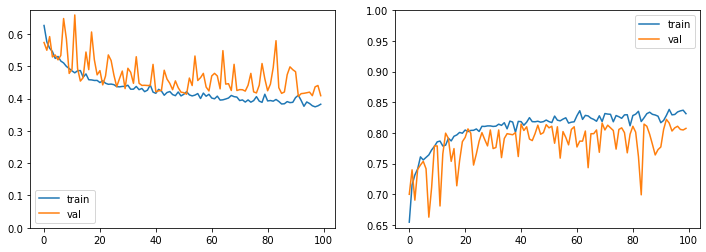

In [11]:
y = np.array([mrk.photo_reqs.unnatural_skin_tone.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'unnatural_skin_tone')
list_model_files.append(model_file)

#### 6. Too Dark/Light 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5822 - accuracy: 0.7028 - precision: 0.9454 - recall: 0.7081 - f1: 0.7888 - specificity: 0.6642 - negative_predictive_value: 0.2788 - matthews_correlation_coefficient: 0.2796 - val_loss: 0.6045 - val_accuracy: 0.6956 - val_precision: 0.9570 - val_recall: 0.6489 - val_f1: 0.7710 - val_specificity: 0.9017 - val_negative_predictive_value: 0.2843 - val_matthews_correlation_coefficient: 0.3576

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.35760, saving model to ../models/autoencoders_requirements/too_dark_light_2020_03_28-20_05_06.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4875 - accuracy: 0.7640 - precision: 0.9663 - recall: 0.7613 - f1: 0.8440 - specificity: 0.8104 - negative_predictive_value: 0.3308 - matthews_correlation_coefficient: 0.4028 - val_loss: 0.4691 - val_accuracy: 0.7979 - val_precisi

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3886 - accuracy: 0.8156 - precision: 0.9744 - recall: 0.8161 - f1: 0.8848 - specificity: 0.8185 - negative_predictive_value: 0.3899 - matthews_correlation_coefficient: 0.4710 - val_loss: 0.3522 - val_accuracy: 0.8569 - val_precision: 0.9530 - val_recall: 0.8338 - val_f1: 0.8879 - val_specificity: 0.8422 - val_negative_predictive_value: 0.4393 - val_matthews_correlation_coefficient: 0.5314

Epoch 00015: val_matthews_correlation_coefficient improved from 0.50613 to 0.53137, saving model to ../models/autoencoders_requirements/too_dark_light_2020_03_28-20_05_06.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3692 - accuracy: 0.8336 - precision: 0.9751 - recall: 0.8326 - f1: 0.8940 - specificity: 0.8596 - negative_predictive_value: 0.4222 - matthews_correlation_coefficient: 0.5151 - val_loss: 0.5536 - val_accuracy: 0.7459 - val_precision: 0.9624 - val_recall: 0.7017 - val_f1: 0.8085 - val_s


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.56002
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3541 - accuracy: 0.8356 - precision: 0.9764 - recall: 0.8366 - f1: 0.8989 - specificity: 0.8251 - negative_predictive_value: 0.4100 - matthews_correlation_coefficient: 0.4990 - val_loss: 0.4300 - val_accuracy: 0.8187 - val_precision: 0.9615 - val_recall: 0.7827 - val_f1: 0.8611 - val_specificity: 0.9153 - val_negative_predictive_value: 0.3973 - val_matthews_correlation_coefficient: 0.4910

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.56002
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3440 - accuracy: 0.8375 - precision: 0.9788 - recall: 0.8324 - f1: 0.8976 - specificity: 0.8568 - negative_predictive_value: 0.4120 - matthews_correlation_coefficient: 0.5114 - val_loss: 0.3664 - val_accuracy: 0.8439 - val_precision: 0.9597 - val_recall: 0.8130 - val_f1: 0.8782 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.56002
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3438 - accuracy: 0.8325 - precision: 0.9808 - recall: 0.8254 - f1: 0.8938 - specificity: 0.8577 - negative_predictive_value: 0.4149 - matthews_correlation_coefficient: 0.5143 - val_loss: 0.6764 - val_accuracy: 0.6990 - val_precision: 0.9625 - val_recall: 0.6496 - val_f1: 0.7719 - val_specificity: 0.9261 - val_negative_predictive_value: 0.2973 - val_matthews_correlation_coefficient: 0.3800

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.56002
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3240 - accuracy: 0.8401 - precision: 0.9827 - recall: 0.8352 - f1: 0.9006 - specificity: 0.8683 - negative_predictive_value: 0.4225 - matthews_correlation_coefficient: 0.5248 - val_loss: 0.3353 - val_accuracy: 0.8621 - val_precision: 0.9579 - val_recall: 0.8354 - val_f1: 0.8909 - val_spe

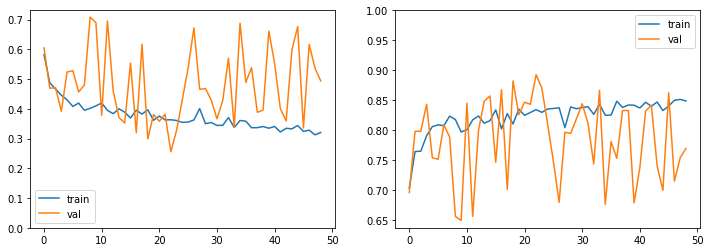

In [12]:
y = np.array([mrk.photo_reqs.too_dark_light.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'too_dark_light')
list_model_files.append(model_file)

#### 7. Washed Out

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6064 - accuracy: 0.7874 - precision: 0.9968 - recall: 0.7869 - f1: 0.8684 - specificity: 0.1724 - negative_predictive_value: 0.0345 - matthews_correlation_coefficient: 0.0621 - val_loss: 0.6065 - val_accuracy: 0.6592 - val_precision: 1.0000 - val_recall: 0.6649 - val_f1: 0.7948 - val_specificity: 0.2432 - val_negative_predictive_value: 0.0269 - val_matthews_correlation_coefficient: 0.0657

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.06573, saving model to ../models/autoencoders_requirements/washed_out_2020_03_28-20_12_26.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5361 - accuracy: 0.6924 - precision: 0.9984 - recall: 0.6927 - f1: 0.8126 - specificity: 0.2138 - negative_predictive_value: 0.0248 - matthews_correlation_coefficient: 0.0556 - val_loss: 0.2141 - val_accuracy: 0.9020 - val_precision: 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2344 - accuracy: 0.9380 - precision: 0.9991 - recall: 0.9354 - f1: 0.9643 - specificity: 0.2448 - negative_predictive_value: 0.1321 - matthews_correlation_coefficient: 0.1677 - val_loss: 0.3147 - val_accuracy: 0.8500 - val_precision: 0.9989 - val_recall: 0.8536 - val_f1: 0.9191 - val_specificity: 0.2297 - val_negative_predictive_value: 0.0615 - val_matthews_correlation_coefficient: 0.1088

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.19674
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2571 - accuracy: 0.9180 - precision: 0.9994 - recall: 0.9150 - f1: 0.9506 - specificity: 0.2759 - negative_predictive_value: 0.1228 - matthews_correlation_coefficient: 0.1665 - val_loss: 0.2438 - val_accuracy: 0.8907 - val_precision: 0.9989 - val_recall: 0.8936 - val_f1: 0.9424 - val_specificity: 0.2297 - val_negative_predictive_value: 0.0804 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1518 - accuracy: 0.9679 - precision: 0.9996 - recall: 0.9682 - f1: 0.9833 - specificity: 0.2552 - negative_predictive_value: 0.1717 - matthews_correlation_coefficient: 0.2001 - val_loss: 0.1336 - val_accuracy: 0.9610 - val_precision: 0.9990 - val_recall: 0.9626 - val_f1: 0.9802 - val_specificity: 0.2297 - val_negative_predictive_value: 0.1779 - val_matthews_correlation_coefficient: 0.1957

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.21485
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1424 - accuracy: 0.9451 - precision: 0.9993 - recall: 0.9457 - f1: 0.9693 - specificity: 0.2552 - negative_predictive_value: 0.1392 - matthews_correlation_coefficient: 0.1776 - val_loss: 0.0912 - val_accuracy: 0.9766 - val_precision: 0.9991 - val_recall: 0.9778 - val_f1: 0.9881 - val_specificity: 0.2297 - val_negative_predictive_value: 0.1937 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1034 - accuracy: 0.9738 - precision: 0.9998 - recall: 0.9707 - f1: 0.9842 - specificity: 0.2483 - negative_predictive_value: 0.1833 - matthews_correlation_coefficient: 0.2074 - val_loss: 0.1435 - val_accuracy: 0.9740 - val_precision: 0.9991 - val_recall: 0.9754 - val_f1: 0.9869 - val_specificity: 0.2297 - val_negative_predictive_value: 0.1982 - val_matthews_correlation_coefficient: 0.2087

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.21485
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1272 - accuracy: 0.9675 - precision: 0.9996 - recall: 0.9679 - f1: 0.9826 - specificity: 0.2759 - negative_predictive_value: 0.2014 - matthews_correlation_coefficient: 0.2267 - val_loss: 0.1412 - val_accuracy: 0.9566 - val_precision: 0.9991 - val_recall: 0.9584 - val_f1: 0.9778 - val_specificity: 0.2297 - val_negative_predictive_value: 0.1811 - val_matthews_correlation_coefficie


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.22679
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1231 - accuracy: 0.9503 - precision: 0.9996 - recall: 0.9507 - f1: 0.9735 - specificity: 0.2483 - negative_predictive_value: 0.1639 - matthews_correlation_coefficient: 0.1908 - val_loss: 0.0587 - val_accuracy: 0.9853 - val_precision: 0.9991 - val_recall: 0.9864 - val_f1: 0.9926 - val_specificity: 0.2297 - val_negative_predictive_value: 0.2162 - val_matthews_correlation_coefficient: 0.2186

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.22679
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1000 - accuracy: 0.9722 - precision: 0.9996 - recall: 0.9727 - f1: 0.9856 - specificity: 0.2552 - negative_predictive_value: 0.2040 - matthews_correlation_coefficient: 0.2232 - val_loss: 0.1200 - val_accuracy: 0.9748 - val_precision: 0.9991 - val_recall: 0.9763 - val_f1: 0.9873 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.22679
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1445 - accuracy: 0.9495 - precision: 0.9993 - recall: 0.9500 - f1: 0.9730 - specificity: 0.2276 - negative_predictive_value: 0.1420 - matthews_correlation_coefficient: 0.1699 - val_loss: 0.2068 - val_accuracy: 0.9324 - val_precision: 0.9721 - val_recall: 0.9085 - val_f1: 0.9384 - val_specificity: 0.2297 - val_negative_predictive_value: 0.1306 - val_matthews_correlation_coefficient: 0.1667

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.22679
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0885 - accuracy: 0.9809 - precision: 0.9998 - recall: 0.9811 - f1: 0.9902 - specificity: 0.2517 - negative_predictive_value: 0.1989 - matthews_correlation_coefficient: 0.2178 - val_loss: 0.1776 - val_accuracy: 0.9480 - val_precision: 0.9991 - val_recall: 0.9499 - val_f1: 0.9733 - val_spe

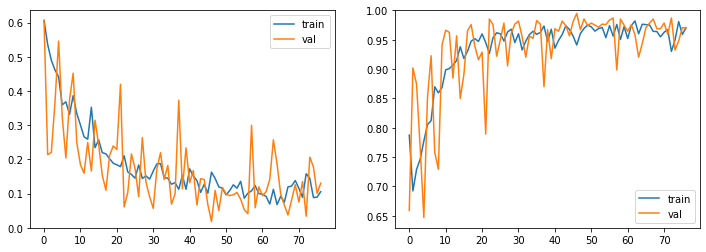

In [13]:
y = np.array([mrk.photo_reqs.washed_out.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'washed_out')
list_model_files.append(model_file)

#### 8. Pixelation

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6689 - accuracy: 0.5601 - precision: 0.9501 - recall: 0.5499 - f1: 0.6815 - specificity: 0.6222 - negative_predictive_value: 0.1110 - matthews_correlation_coefficient: 0.1284 - val_loss: 0.8329 - val_accuracy: 0.4805 - val_precision: 0.9717 - val_recall: 0.4704 - val_f1: 0.6253 - val_specificity: 0.6748 - val_negative_predictive_value: 0.0923 - val_matthews_correlation_coefficient: 0.1100

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.11001, saving model to ../models/autoencoders_requirements/pixelation_2020_03_28-20_23_54.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6376 - accuracy: 0.6358 - precision: 0.9634 - recall: 0.6369 - f1: 0.7551 - specificity: 0.5601 - negative_predictive_value: 0.1253 - matthews_correlation_coefficient: 0.1407 - val_loss: 0.5336 - val_accuracy: 0.6895 - val_precision: 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5174 - accuracy: 0.7072 - precision: 0.9768 - recall: 0.7054 - f1: 0.8147 - specificity: 0.6868 - negative_predictive_value: 0.1652 - matthews_correlation_coefficient: 0.2371 - val_loss: 0.4459 - val_accuracy: 0.7676 - val_precision: 0.9664 - val_recall: 0.7839 - val_f1: 0.8630 - val_specificity: 0.5117 - val_negative_predictive_value: 0.1523 - val_matthews_correlation_coefficient: 0.1894

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.21831
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5096 - accuracy: 0.7273 - precision: 0.9755 - recall: 0.7249 - f1: 0.8287 - specificity: 0.6769 - negative_predictive_value: 0.1664 - matthews_correlation_coefficient: 0.2422 - val_loss: 0.3112 - val_accuracy: 0.8500 - val_precision: 0.9591 - val_recall: 0.8798 - val_f1: 0.9167 - val_specificity: 0.4117 - val_negative_predictive_value: 0.1883 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.22074
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4827 - accuracy: 0.7343 - precision: 0.9747 - recall: 0.7246 - f1: 0.8284 - specificity: 0.7363 - negative_predictive_value: 0.1817 - matthews_correlation_coefficient: 0.2686 - val_loss: 0.4602 - val_accuracy: 0.7632 - val_precision: 0.9690 - val_recall: 0.7763 - val_f1: 0.8593 - val_specificity: 0.5590 - val_negative_predictive_value: 0.1538 - val_matthews_correlation_coefficient: 0.2037

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.22074
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5460 - accuracy: 0.6870 - precision: 0.9693 - recall: 0.6852 - f1: 0.7855 - specificity: 0.6923 - negative_predictive_value: 0.1621 - matthews_correlation_coefficient: 0.2311 - val_loss: 0.3351 - val_accuracy: 0.8118 - val_precision: 0.9612 - val_recall: 0.8362 - val_f1: 0.8927 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.22399
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4942 - accuracy: 0.7150 - precision: 0.9789 - recall: 0.7117 - f1: 0.8204 - specificity: 0.7240 - negative_predictive_value: 0.1678 - matthews_correlation_coefficient: 0.2520 - val_loss: 0.3284 - val_accuracy: 0.8300 - val_precision: 0.9628 - val_recall: 0.8539 - val_f1: 0.9038 - val_specificity: 0.4577 - val_negative_predictive_value: 0.1706 - val_matthews_correlation_coefficient: 0.2034

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.22399
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4853 - accuracy: 0.7291 - precision: 0.9777 - recall: 0.7273 - f1: 0.8303 - specificity: 0.6808 - negative_predictive_value: 0.1835 - matthews_correlation_coefficient: 0.2604 - val_loss: 0.4427 - val_accuracy: 0.7381 - val_precision: 0.9680 - val_recall: 0.7502 - val_f1: 0.8426 - val_spe


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.22399
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4675 - accuracy: 0.7328 - precision: 0.9819 - recall: 0.7293 - f1: 0.8347 - specificity: 0.7292 - negative_predictive_value: 0.1818 - matthews_correlation_coefficient: 0.2716 - val_loss: 0.4271 - val_accuracy: 0.7381 - val_precision: 0.9712 - val_recall: 0.7474 - val_f1: 0.8420 - val_specificity: 0.5748 - val_negative_predictive_value: 0.1473 - val_matthews_correlation_coefficient: 0.1962

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.22399
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4717 - accuracy: 0.7308 - precision: 0.9802 - recall: 0.7275 - f1: 0.8314 - specificity: 0.6826 - negative_predictive_value: 0.1769 - matthews_correlation_coefficient: 0.2576 - val_loss: 0.3967 - val_accuracy: 0.7832 - val_precision: 0.9688 - val_recall: 0.7979 - val_f1: 0.8728 - val_spe

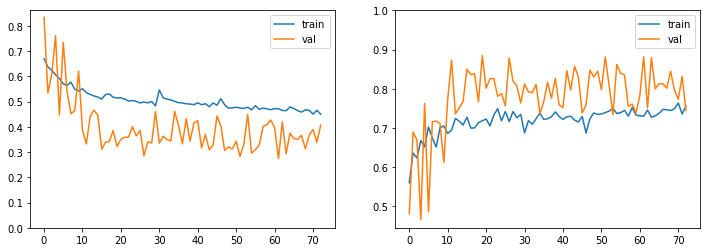

In [14]:
y = np.array([mrk.photo_reqs.pixelation.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'pixelation')
list_model_files.append(model_file)

#### 9. Hair Across Eyes 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5699 - accuracy: 0.6950 - precision: 0.9103 - recall: 0.6593 - f1: 0.7572 - specificity: 0.8003 - negative_predictive_value: 0.4481 - matthews_correlation_coefficient: 0.4048 - val_loss: 0.5492 - val_accuracy: 0.7129 - val_precision: 0.8989 - val_recall: 0.6512 - val_f1: 0.7507 - val_specificity: 0.8518 - val_negative_predictive_value: 0.4807 - val_matthews_correlation_coefficient: 0.4346

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.43464, saving model to ../models/autoencoders_requirements/hair_across_eyes_2020_03_28-20_34_46.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5468 - accuracy: 0.7132 - precision: 0.9174 - recall: 0.6743 - f1: 0.7736 - specificity: 0.8252 - negative_predictive_value: 0.4654 - matthews_correlation_coefficient: 0.4362 - val_loss: 0.5261 - val_accuracy: 0.7173 - val_preci

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5014 - accuracy: 0.7449 - precision: 0.9204 - recall: 0.7212 - f1: 0.8043 - specificity: 0.8167 - negative_predictive_value: 0.5035 - matthews_correlation_coefficient: 0.4765 - val_loss: 0.4949 - val_accuracy: 0.7441 - val_precision: 0.8960 - val_recall: 0.6985 - val_f1: 0.7821 - val_specificity: 0.8261 - val_negative_predictive_value: 0.5078 - val_matthews_correlation_coefficient: 0.4580

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.46319
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4987 - accuracy: 0.7466 - precision: 0.9206 - recall: 0.7210 - f1: 0.8042 - specificity: 0.8183 - negative_predictive_value: 0.5058 - matthews_correlation_coefficient: 0.4788 - val_loss: 0.5487 - val_accuracy: 0.7259 - val_precision: 0.8984 - val_recall: 0.6708 - val_f1: 0.7649 - val_specificity: 0.8399 - val_negative_predictive_value: 0.4894 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.48090
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4738 - accuracy: 0.7625 - precision: 0.9233 - recall: 0.7419 - f1: 0.8174 - specificity: 0.8089 - negative_predictive_value: 0.5280 - matthews_correlation_coefficient: 0.4974 - val_loss: 0.4818 - val_accuracy: 0.7780 - val_precision: 0.8763 - val_recall: 0.7684 - val_f1: 0.8163 - val_specificity: 0.7433 - val_negative_predictive_value: 0.5502 - val_matthews_correlation_coefficient: 0.4650

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.48090
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4704 - accuracy: 0.7640 - precision: 0.9212 - recall: 0.7482 - f1: 0.8215 - specificity: 0.8162 - negative_predictive_value: 0.5320 - matthews_correlation_coefficient: 0.5032 - val_loss: 0.5792 - val_accuracy: 0.7329 - val_precision: 0.8973 - val_recall: 0.6805 - val_f1: 0.7708 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.48090
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4735 - accuracy: 0.7525 - precision: 0.9237 - recall: 0.7325 - f1: 0.8114 - specificity: 0.8188 - negative_predictive_value: 0.5193 - matthews_correlation_coefficient: 0.4919 - val_loss: 0.5310 - val_accuracy: 0.7615 - val_precision: 0.8848 - val_recall: 0.7343 - val_f1: 0.8002 - val_specificity: 0.7810 - val_negative_predictive_value: 0.5264 - val_matthews_correlation_coefficient: 0.4585

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.48090
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4633 - accuracy: 0.7649 - precision: 0.9210 - recall: 0.7380 - f1: 0.8143 - specificity: 0.8244 - negative_predictive_value: 0.5371 - matthews_correlation_coefficient: 0.5071 - val_loss: 0.5198 - val_accuracy: 0.7407 - val_precision: 0.8880 - val_recall: 0.7014 - val_f1: 0.7813 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4557 - accuracy: 0.7735 - precision: 0.9310 - recall: 0.7577 - f1: 0.8300 - specificity: 0.8163 - negative_predictive_value: 0.5417 - matthews_correlation_coefficient: 0.5189 - val_loss: 0.4905 - val_accuracy: 0.7814 - val_precision: 0.8829 - val_recall: 0.7648 - val_f1: 0.8165 - val_specificity: 0.7621 - val_negative_predictive_value: 0.5609 - val_matthews_correlation_coefficient: 0.4815

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.50085
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4517 - accuracy: 0.7731 - precision: 0.9261 - recall: 0.7580 - f1: 0.8286 - specificity: 0.8126 - negative_predictive_value: 0.5383 - matthews_correlation_coefficient: 0.5126 - val_loss: 0.5187 - val_accuracy: 0.7311 - val_precision: 0.8966 - val_recall: 0.6772 - val_f1: 0.7691 - val_specificity: 0.8341 - val_negative_predictive_value: 0.4948 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4389 - accuracy: 0.7818 - precision: 0.9325 - recall: 0.7642 - f1: 0.8350 - specificity: 0.8334 - negative_predictive_value: 0.5523 - matthews_correlation_coefficient: 0.5362 - val_loss: 0.5463 - val_accuracy: 0.7233 - val_precision: 0.9076 - val_recall: 0.6569 - val_f1: 0.7589 - val_specificity: 0.8507 - val_negative_predictive_value: 0.4852 - val_matthews_correlation_coefficient: 0.4447

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.50085
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4387 - accuracy: 0.7794 - precision: 0.9340 - recall: 0.7585 - f1: 0.8333 - specificity: 0.8535 - negative_predictive_value: 0.5509 - matthews_correlation_coefficient: 0.5420 - val_loss: 0.5604 - val_accuracy: 0.7138 - val_precision: 0.9025 - val_recall: 0.6491 - val_f1: 0.7528 - val_specificity: 0.8401 - val_negative_predictive_value: 0.4741 - val_matthews_correlation_coefficie


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.50647
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4300 - accuracy: 0.7833 - precision: 0.9291 - recall: 0.7579 - f1: 0.8298 - specificity: 0.8383 - negative_predictive_value: 0.5577 - matthews_correlation_coefficient: 0.5376 - val_loss: 0.5742 - val_accuracy: 0.7173 - val_precision: 0.9079 - val_recall: 0.6487 - val_f1: 0.7542 - val_specificity: 0.8512 - val_negative_predictive_value: 0.4778 - val_matthews_correlation_coefficient: 0.4372

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.50647
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4340 - accuracy: 0.7759 - precision: 0.9327 - recall: 0.7532 - f1: 0.8276 - specificity: 0.8343 - negative_predictive_value: 0.5417 - matthews_correlation_coefficient: 0.5281 - val_loss: 0.5686 - val_accuracy: 0.7025 - val_precision: 0.9174 - val_recall: 0.6213 - val_f1: 0.7377 - val_spe

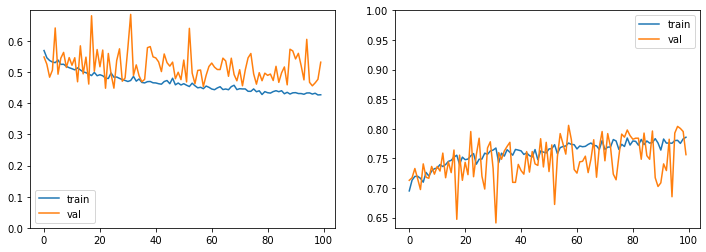

In [15]:
y = np.array([mrk.photo_reqs.hair_across_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'hair_across_eyes')
list_model_files.append(model_file)

#### 10. Eyes Closed  

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6551 - accuracy: 0.5367 - precision: 0.8840 - recall: 0.4685 - f1: 0.6016 - specificity: 0.7794 - negative_predictive_value: 0.3003 - matthews_correlation_coefficient: 0.2126 - val_loss: 0.6779 - val_accuracy: 0.5221 - val_precision: 0.8683 - val_recall: 0.4273 - val_f1: 0.5652 - val_specificity: 0.8044 - val_negative_predictive_value: 0.2933 - val_matthews_correlation_coefficient: 0.2200

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.22004, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_28-20_49_34.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6463 - accuracy: 0.5534 - precision: 0.8891 - recall: 0.4915 - f1: 0.6215 - specificity: 0.7632 - negative_predictive_value: 0.2993 - matthews_correlation_coefficient: 0.2188 - val_loss: 0.6313 - val_accuracy: 0.5559 - val_precision


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.33323
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6062 - accuracy: 0.6341 - precision: 0.8997 - recall: 0.6002 - f1: 0.7102 - specificity: 0.7521 - negative_predictive_value: 0.3521 - matthews_correlation_coefficient: 0.2967 - val_loss: 0.6290 - val_accuracy: 0.6227 - val_precision: 0.8878 - val_recall: 0.5569 - val_f1: 0.6791 - val_specificity: 0.7970 - val_negative_predictive_value: 0.3479 - val_matthews_correlation_coefficient: 0.3152

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.33323
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5966 - accuracy: 0.6547 - precision: 0.8936 - recall: 0.6298 - f1: 0.7286 - specificity: 0.7381 - negative_predictive_value: 0.3689 - matthews_correlation_coefficient: 0.3151 - val_loss: 0.5965 - val_accuracy: 0.6548 - val_precision: 0.8813 - val_recall: 0.6064 - val_f1: 0.7134 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5769 - accuracy: 0.6757 - precision: 0.8987 - recall: 0.6588 - f1: 0.7504 - specificity: 0.7302 - negative_predictive_value: 0.3967 - matthews_correlation_coefficient: 0.3380 - val_loss: 0.4988 - val_accuracy: 0.7459 - val_precision: 0.8514 - val_recall: 0.7669 - val_f1: 0.8038 - val_specificity: 0.6002 - val_negative_predictive_value: 0.4477 - val_matthews_correlation_coefficient: 0.3556

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.36099
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5682 - accuracy: 0.6948 - precision: 0.8966 - recall: 0.6781 - f1: 0.7656 - specificity: 0.7316 - negative_predictive_value: 0.4103 - matthews_correlation_coefficient: 0.3583 - val_loss: 0.4979 - val_accuracy: 0.7424 - val_precision: 0.8481 - val_recall: 0.7666 - val_f1: 0.8020 - val_specificity: 0.5832 - val_negative_predictive_value: 0.4416 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.36210
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5467 - accuracy: 0.7048 - precision: 0.9048 - recall: 0.6948 - f1: 0.7779 - specificity: 0.7373 - negative_predictive_value: 0.4147 - matthews_correlation_coefficient: 0.3717 - val_loss: 0.5586 - val_accuracy: 0.6860 - val_precision: 0.9030 - val_recall: 0.6796 - val_f1: 0.7710 - val_specificity: 0.7322 - val_negative_predictive_value: 0.3879 - val_matthews_correlation_coefficient: 0.3448

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.36210
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5472 - accuracy: 0.6972 - precision: 0.9127 - recall: 0.6772 - f1: 0.7706 - specificity: 0.7560 - negative_predictive_value: 0.4073 - matthews_correlation_coefficient: 0.3713 - val_loss: 0.5191 - val_accuracy: 0.7294 - val_precision: 0.8707 - val_recall: 0.7781 - val_f1: 0.8186 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.37516
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5339 - accuracy: 0.7139 - precision: 0.9038 - recall: 0.7087 - f1: 0.7866 - specificity: 0.7348 - negative_predictive_value: 0.4211 - matthews_correlation_coefficient: 0.3789 - val_loss: 0.5706 - val_accuracy: 0.6930 - val_precision: 0.8787 - val_recall: 0.6643 - val_f1: 0.7525 - val_specificity: 0.7360 - val_negative_predictive_value: 0.3932 - val_matthews_correlation_coefficient: 0.3560

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.37516
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5443 - accuracy: 0.7017 - precision: 0.9045 - recall: 0.6961 - f1: 0.7803 - specificity: 0.7369 - negative_predictive_value: 0.4073 - matthews_correlation_coefficient: 0.3643 - val_loss: 0.6072 - val_accuracy: 0.6670 - val_precision: 0.8927 - val_recall: 0.6129 - val_f1: 0.7233 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.38658
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5291 - accuracy: 0.7085 - precision: 0.9144 - recall: 0.6938 - f1: 0.7820 - specificity: 0.7479 - negative_predictive_value: 0.4230 - matthews_correlation_coefficient: 0.3848 - val_loss: 0.5694 - val_accuracy: 0.7207 - val_precision: 0.9076 - val_recall: 0.7248 - val_f1: 0.8022 - val_specificity: 0.7316 - val_negative_predictive_value: 0.4244 - val_matthews_correlation_coefficient: 0.3877

Epoch 00074: val_matthews_correlation_coefficient improved from 0.38658 to 0.38771, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_28-20_49_34.h5
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5203 - accuracy: 0.7197 - precision: 0.9118 - recall: 0.7127 - f1: 0.7947 - specificity: 0.7527 - negative_predictive_value: 0.4347 - matthews_correlation_coefficient: 0.3981 - val_loss: 0.6978 - 


Epoch 00088: val_matthews_correlation_coefficient improved from 0.38771 to 0.39262, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_28-20_49_34.h5
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5055 - accuracy: 0.7295 - precision: 0.9169 - recall: 0.7227 - f1: 0.8021 - specificity: 0.7739 - negative_predictive_value: 0.4500 - matthews_correlation_coefficient: 0.4233 - val_loss: 0.4784 - val_accuracy: 0.7572 - val_precision: 0.8465 - val_recall: 0.8526 - val_f1: 0.8468 - val_specificity: 0.4422 - val_negative_predictive_value: 0.4465 - val_matthews_correlation_coefficient: 0.2903

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.39262
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5203 - accuracy: 0.7119 - precision: 0.9053 - recall: 0.6944 - f1: 0.7801 - specificity: 0.7606 - negative_predictive_value: 0.4220 - matthews_correlation_coefficient: 0.3887 - val_loss: 0.5826 - 

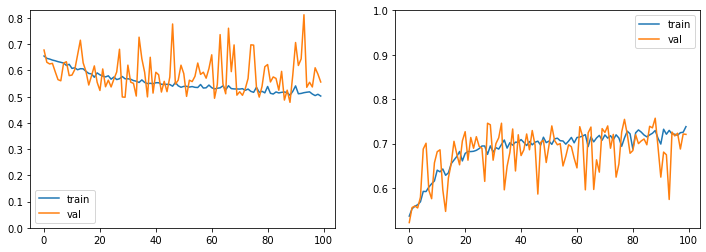

In [16]:
y = np.array([mrk.photo_reqs.eyes_closed.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'eyes_closed')
list_model_files.append(model_file)

#### 11. Varied Background

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5092 - accuracy: 0.7315 - precision: 0.7983 - recall: 0.7044 - f1: 0.7255 - specificity: 0.7716 - negative_predictive_value: 0.7032 - matthews_correlation_coefficient: 0.4886 - val_loss: 0.4809 - val_accuracy: 0.7311 - val_precision: 0.9102 - val_recall: 0.5923 - val_f1: 0.7083 - val_specificity: 0.8982 - val_negative_predictive_value: 0.6222 - val_matthews_correlation_coefficient: 0.5101

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.51012, saving model to ../models/autoencoders_requirements/varied_background_2020_03_28-21_07_01.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4285 - accuracy: 0.7751 - precision: 0.8232 - recall: 0.7581 - f1: 0.7762 - specificity: 0.8050 - negative_predictive_value: 0.7410 - matthews_correlation_coefficient: 0.5647 - val_loss: 0.3958 - val_accuracy: 0.7901 - val_prec


Epoch 00014: val_matthews_correlation_coefficient improved from 0.67630 to 0.68026, saving model to ../models/autoencoders_requirements/varied_background_2020_03_28-21_07_01.h5
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3432 - accuracy: 0.8293 - precision: 0.8622 - recall: 0.8314 - f1: 0.8397 - specificity: 0.8388 - negative_predictive_value: 0.8055 - matthews_correlation_coefficient: 0.6686 - val_loss: 0.3314 - val_accuracy: 0.8326 - val_precision: 0.9288 - val_recall: 0.7709 - val_f1: 0.8374 - val_specificity: 0.8987 - val_negative_predictive_value: 0.7370 - val_matthews_correlation_coefficient: 0.6673

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.68026
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3373 - accuracy: 0.8395 - precision: 0.8771 - recall: 0.8329 - f1: 0.8489 - specificity: 0.8591 - negative_predictive_value: 0.8049 - matthews_correlation_coefficient: 0.6866 - val_loss: 0.3


Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.72332
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3128 - accuracy: 0.8464 - precision: 0.8791 - recall: 0.8400 - f1: 0.8528 - specificity: 0.8534 - negative_predictive_value: 0.8107 - matthews_correlation_coefficient: 0.6930 - val_loss: 0.2989 - val_accuracy: 0.8569 - val_precision: 0.8900 - val_recall: 0.8586 - val_f1: 0.8708 - val_specificity: 0.8410 - val_negative_predictive_value: 0.7997 - val_matthews_correlation_coefficient: 0.6944

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.72332
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3134 - accuracy: 0.8460 - precision: 0.8814 - recall: 0.8389 - f1: 0.8535 - specificity: 0.8508 - negative_predictive_value: 0.8102 - matthews_correlation_coefficient: 0.6921 - val_loss: 0.2860 - val_accuracy: 0.8543 - val_precision: 0.9068 - val_recall: 0.8323 - val_f1: 0.8640 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2926 - accuracy: 0.8564 - precision: 0.8840 - recall: 0.8592 - f1: 0.8667 - specificity: 0.8545 - negative_predictive_value: 0.8267 - matthews_correlation_coefficient: 0.7119 - val_loss: 0.2820 - val_accuracy: 0.8647 - val_precision: 0.8924 - val_recall: 0.8674 - val_f1: 0.8771 - val_specificity: 0.8433 - val_negative_predictive_value: 0.8111 - val_matthews_correlation_coefficient: 0.7069

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.73460
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2979 - accuracy: 0.8544 - precision: 0.8838 - recall: 0.8523 - f1: 0.8636 - specificity: 0.8638 - negative_predictive_value: 0.8249 - matthews_correlation_coefficient: 0.7122 - val_loss: 0.2699 - val_accuracy: 0.8820 - val_precision: 0.8736 - val_recall: 0.9318 - val_f1: 0.8982 - val_specificity: 0.8041 - val_negative_predictive_value: 0.8774 - val_matthews_correlation_coefficie


Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.74618
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2900 - accuracy: 0.8616 - precision: 0.8931 - recall: 0.8565 - f1: 0.8694 - specificity: 0.8665 - negative_predictive_value: 0.8236 - matthews_correlation_coefficient: 0.7211 - val_loss: 0.2748 - val_accuracy: 0.8673 - val_precision: 0.9058 - val_recall: 0.8569 - val_f1: 0.8780 - val_specificity: 0.8635 - val_negative_predictive_value: 0.8041 - val_matthews_correlation_coefficient: 0.7149

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.74618
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2780 - accuracy: 0.8610 - precision: 0.8897 - recall: 0.8573 - f1: 0.8696 - specificity: 0.8721 - negative_predictive_value: 0.8313 - matthews_correlation_coefficient: 0.7248 - val_loss: 0.3074 - val_accuracy: 0.8491 - val_precision: 0.8059 - val_recall: 0.9753 - val_f1: 0.8788 - val_spe


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.75496
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2686 - accuracy: 0.8698 - precision: 0.8953 - recall: 0.8545 - f1: 0.8712 - specificity: 0.8827 - negative_predictive_value: 0.8356 - matthews_correlation_coefficient: 0.7355 - val_loss: 0.2667 - val_accuracy: 0.8708 - val_precision: 0.9025 - val_recall: 0.8682 - val_f1: 0.8820 - val_specificity: 0.8542 - val_negative_predictive_value: 0.8163 - val_matthews_correlation_coefficient: 0.7204

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.75496
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2765 - accuracy: 0.8629 - precision: 0.8957 - recall: 0.8550 - f1: 0.8697 - specificity: 0.8771 - negative_predictive_value: 0.8346 - matthews_correlation_coefficient: 0.7309 - val_loss: 0.2693 - val_accuracy: 0.8734 - val_precision: 0.8943 - val_recall: 0.8808 - val_f1: 0.8853 - val_spe


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.75496
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2632 - accuracy: 0.8742 - precision: 0.9067 - recall: 0.8685 - f1: 0.8826 - specificity: 0.8798 - negative_predictive_value: 0.8362 - matthews_correlation_coefficient: 0.7453 - val_loss: 0.2894 - val_accuracy: 0.8682 - val_precision: 0.8571 - val_recall: 0.9224 - val_f1: 0.8860 - val_specificity: 0.7815 - val_negative_predictive_value: 0.8649 - val_matthews_correlation_coefficient: 0.7126

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.75496
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2599 - accuracy: 0.8709 - precision: 0.8937 - recall: 0.8676 - f1: 0.8754 - specificity: 0.8720 - negative_predictive_value: 0.8379 - matthews_correlation_coefficient: 0.7369 - val_loss: 0.2821 - val_accuracy: 0.8638 - val_precision: 0.8291 - val_recall: 0.9652 - val_f1: 0.8882 - val_spe

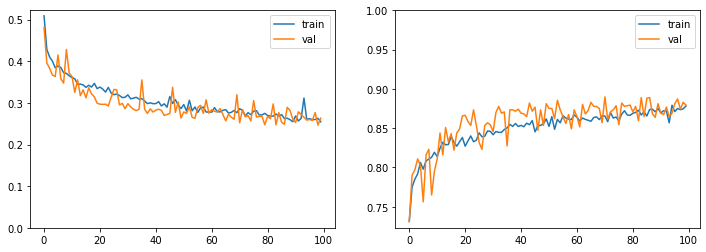

In [17]:
y = np.array([mrk.photo_reqs.varied_background.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'varied_background')
list_model_files.append(model_file)

#### 12. Roll/pitch/yaw

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5903 - accuracy: 0.7074 - precision: 0.8957 - recall: 0.6935 - f1: 0.7764 - specificity: 0.7504 - negative_predictive_value: 0.4527 - matthews_correlation_coefficient: 0.3921 - val_loss: 0.5505 - val_accuracy: 0.7051 - val_precision: 0.8812 - val_recall: 0.6601 - val_f1: 0.7516 - val_specificity: 0.7990 - val_negative_predictive_value: 0.4620 - val_matthews_correlation_coefficient: 0.3948

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.39482, saving model to ../models/autoencoders_requirements/roll_pitch_yaw_2020_03_28-21_21_49.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5727 - accuracy: 0.7087 - precision: 0.9097 - recall: 0.6794 - f1: 0.7735 - specificity: 0.7956 - negative_predictive_value: 0.4525 - matthews_correlation_coefficient: 0.4141 - val_loss: 0.5225 - val_accuracy: 0.7121 - val_precisi

4610/4610 [==============================] - 40s 9ms/step - loss: 0.5579 - accuracy: 0.7124 - precision: 0.9096 - recall: 0.6838 - f1: 0.7767 - specificity: 0.7964 - negative_predictive_value: 0.4584 - matthews_correlation_coefficient: 0.4199 - val_loss: 0.6248 - val_accuracy: 0.7034 - val_precision: 0.8994 - val_recall: 0.6423 - val_f1: 0.7464 - val_specificity: 0.8473 - val_negative_predictive_value: 0.4622 - val_matthews_correlation_coefficient: 0.4182

Epoch 00015: val_matthews_correlation_coefficient improved from 0.41683 to 0.41816, saving model to ../models/autoencoders_requirements/roll_pitch_yaw_2020_03_28-21_21_49.h5
Epoch 16/100
4610/4610 [==============================] - 24s 5ms/step - loss: 0.5606 - accuracy: 0.7115 - precision: 0.9096 - recall: 0.6813 - f1: 0.7747 - specificity: 0.7897 - negative_predictive_value: 0.4568 - matthews_correlation_coefficient: 0.4150 - val_loss: 0.5573 - val_accuracy: 0.7051 - val_precision: 0.8867 - val_recall: 0.6551 - val_f1: 0.7500 - val


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.41816
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5497 - accuracy: 0.7143 - precision: 0.9111 - recall: 0.6857 - f1: 0.7784 - specificity: 0.7958 - negative_predictive_value: 0.4576 - matthews_correlation_coefficient: 0.4209 - val_loss: 0.5339 - val_accuracy: 0.7242 - val_precision: 0.8686 - val_recall: 0.6976 - val_f1: 0.7709 - val_specificity: 0.7588 - val_negative_predictive_value: 0.4788 - val_matthews_correlation_coefficient: 0.3963

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.41816
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5496 - accuracy: 0.7202 - precision: 0.9078 - recall: 0.6987 - f1: 0.7849 - specificity: 0.8063 - negative_predictive_value: 0.4654 - matthews_correlation_coefficient: 0.4332 - val_loss: 0.5804 - val_accuracy: 0.7147 - val_precision: 0.8835 - val_recall: 0.6708 - val_f1: 0.7592 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5475 - accuracy: 0.7113 - precision: 0.9148 - recall: 0.6771 - f1: 0.7749 - specificity: 0.8057 - negative_predictive_value: 0.4521 - matthews_correlation_coefficient: 0.4204 - val_loss: 0.5028 - val_accuracy: 0.7294 - val_precision: 0.8588 - val_recall: 0.7162 - val_f1: 0.7776 - val_specificity: 0.7310 - val_negative_predictive_value: 0.4891 - val_matthews_correlation_coefficient: 0.3922

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.42582
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5493 - accuracy: 0.7182 - precision: 0.9104 - recall: 0.6923 - f1: 0.7822 - specificity: 0.8034 - negative_predictive_value: 0.4624 - matthews_correlation_coefficient: 0.4297 - val_loss: 0.5218 - val_accuracy: 0.7251 - val_precision: 0.8818 - val_recall: 0.6874 - val_f1: 0.7690 - val_specificity: 0.7994 - val_negative_predictive_value: 0.4839 - val_matthews_correlation_coefficie


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.42599
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5422 - accuracy: 0.7213 - precision: 0.9130 - recall: 0.6940 - f1: 0.7855 - specificity: 0.7915 - negative_predictive_value: 0.4651 - matthews_correlation_coefficient: 0.4286 - val_loss: 0.5253 - val_accuracy: 0.7251 - val_precision: 0.8894 - val_recall: 0.6805 - val_f1: 0.7672 - val_specificity: 0.8173 - val_negative_predictive_value: 0.4839 - val_matthews_correlation_coefficient: 0.4288

Epoch 00059: val_matthews_correlation_coefficient improved from 0.42599 to 0.42875, saving model to ../models/autoencoders_requirements/roll_pitch_yaw_2020_03_28-21_21_49.h5
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5392 - accuracy: 0.7202 - precision: 0.9120 - recall: 0.6974 - f1: 0.7857 - specificity: 0.7932 - negative_predictive_value: 0.4646 - matthews_correlation_coefficient: 0.4276 - val_loss: 0.5758


Epoch 00073: val_matthews_correlation_coefficient improved from 0.42875 to 0.42908, saving model to ../models/autoencoders_requirements/roll_pitch_yaw_2020_03_28-21_21_49.h5
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5405 - accuracy: 0.7239 - precision: 0.9158 - recall: 0.6947 - f1: 0.7863 - specificity: 0.8039 - negative_predictive_value: 0.4681 - matthews_correlation_coefficient: 0.4373 - val_loss: 0.5287 - val_accuracy: 0.7251 - val_precision: 0.8808 - val_recall: 0.6882 - val_f1: 0.7696 - val_specificity: 0.7934 - val_negative_predictive_value: 0.4815 - val_matthews_correlation_coefficient: 0.4153

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.42908
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5371 - accuracy: 0.7228 - precision: 0.9096 - recall: 0.6998 - f1: 0.7864 - specificity: 0.7905 - negative_predictive_value: 0.4623 - matthews_correlation_coefficient: 0.4264 - val_loss: 0.5501

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5334 - accuracy: 0.7230 - precision: 0.9190 - recall: 0.6945 - f1: 0.7877 - specificity: 0.8130 - negative_predictive_value: 0.4724 - matthews_correlation_coefficient: 0.4437 - val_loss: 0.5138 - val_accuracy: 0.7320 - val_precision: 0.8738 - val_recall: 0.7052 - val_f1: 0.7774 - val_specificity: 0.7663 - val_negative_predictive_value: 0.4894 - val_matthews_correlation_coefficient: 0.4116

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.43058
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5313 - accuracy: 0.7228 - precision: 0.9102 - recall: 0.6898 - f1: 0.7810 - specificity: 0.8100 - negative_predictive_value: 0.4753 - matthews_correlation_coefficient: 0.4386 - val_loss: 0.5438 - val_accuracy: 0.7112 - val_precision: 0.8839 - val_recall: 0.6660 - val_f1: 0.7562 - val_specificity: 0.8059 - val_negative_predictive_value: 0.4680 - val_matthews_correlation_coefficie

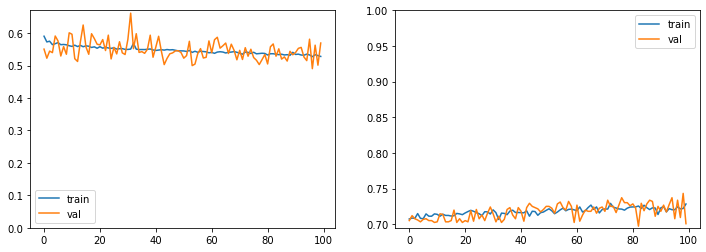

In [18]:
y = np.array([mrk.photo_reqs.roll_pitch_yaw.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'roll_pitch_yaw')
list_model_files.append(model_file)

#### 13. Flash Reflection on Skin

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6044 - accuracy: 0.6725 - precision: 0.7211 - recall: 0.6384 - f1: 0.6501 - specificity: 0.7115 - negative_predictive_value: 0.6695 - matthews_correlation_coefficient: 0.3703 - val_loss: 0.5794 - val_accuracy: 0.6652 - val_precision: 0.7875 - val_recall: 0.5269 - val_f1: 0.6240 - val_specificity: 0.8151 - val_negative_predictive_value: 0.5846 - val_matthews_correlation_coefficient: 0.3561

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.35608, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_28-21_37_40.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5589 - accuracy: 0.7139 - precision: 0.7411 - recall: 0.7407 - f1: 0.7234 - specificity: 0.6957 - negative_predictive_value: 0.7190 - matthews_correlation_coefficient: 0.4468 - val_loss: 0.5266 - val_accuracy: 0.7251 - 


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.54944
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4475 - accuracy: 0.7837 - precision: 0.7869 - recall: 0.8182 - f1: 0.7955 - specificity: 0.7435 - negative_predictive_value: 0.7842 - matthews_correlation_coefficient: 0.5676 - val_loss: 0.4538 - val_accuracy: 0.7814 - val_precision: 0.8145 - val_recall: 0.7849 - val_f1: 0.7959 - val_specificity: 0.7655 - val_negative_predictive_value: 0.7288 - val_matthews_correlation_coefficient: 0.5467

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.54944
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4416 - accuracy: 0.7905 - precision: 0.7977 - recall: 0.8165 - f1: 0.8006 - specificity: 0.7631 - negative_predictive_value: 0.7791 - matthews_correlation_coefficient: 0.5796 - val_loss: 0.4748 - val_accuracy: 0.7650 - val_precision: 0.8337 - val_recall: 0.7158 - val_f1: 0.7656 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4253 - accuracy: 0.7941 - precision: 0.7974 - recall: 0.8249 - f1: 0.8041 - specificity: 0.7519 - negative_predictive_value: 0.7941 - matthews_correlation_coefficient: 0.5852 - val_loss: 0.4563 - val_accuracy: 0.7866 - val_precision: 0.7941 - val_recall: 0.8228 - val_f1: 0.8051 - val_specificity: 0.7338 - val_negative_predictive_value: 0.7576 - val_matthews_correlation_coefficient: 0.5539

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.57189
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4308 - accuracy: 0.7983 - precision: 0.8120 - recall: 0.8218 - f1: 0.8084 - specificity: 0.7800 - negative_predictive_value: 0.7974 - matthews_correlation_coefficient: 0.6053 - val_loss: 0.4571 - val_accuracy: 0.7788 - val_precision: 0.7922 - val_recall: 0.8145 - val_f1: 0.7990 - val_specificity: 0.7300 - val_negative_predictive_value: 0.7457 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.57885
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4052 - accuracy: 0.8052 - precision: 0.8072 - recall: 0.8405 - f1: 0.8175 - specificity: 0.7690 - negative_predictive_value: 0.8105 - matthews_correlation_coefficient: 0.6132 - val_loss: 0.4444 - val_accuracy: 0.8057 - val_precision: 0.8010 - val_recall: 0.8651 - val_f1: 0.8280 - val_specificity: 0.7272 - val_negative_predictive_value: 0.7951 - val_matthews_correlation_coefficient: 0.5938

Epoch 00044: val_matthews_correlation_coefficient improved from 0.57885 to 0.59385, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_28-21_37_40.h5
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4135 - accuracy: 0.8054 - precision: 0.8024 - recall: 0.8313 - f1: 0.8110 - specificity: 0.7747 - negative_predictive_value: 0.8044 - matthews_correlation_coefficient: 0.6078 - val_lo


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.59385
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3842 - accuracy: 0.8265 - precision: 0.8219 - recall: 0.8611 - f1: 0.8355 - specificity: 0.7887 - negative_predictive_value: 0.8290 - matthews_correlation_coefficient: 0.6517 - val_loss: 0.4467 - val_accuracy: 0.7927 - val_precision: 0.7889 - val_recall: 0.8478 - val_f1: 0.8138 - val_specificity: 0.7186 - val_negative_predictive_value: 0.7801 - val_matthews_correlation_coefficient: 0.5674

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.59385
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3979 - accuracy: 0.8100 - precision: 0.8236 - recall: 0.8287 - f1: 0.8203 - specificity: 0.7891 - negative_predictive_value: 0.7952 - matthews_correlation_coefficient: 0.6180 - val_loss: 0.4489 - val_accuracy: 0.7884 - val_precision: 0.7811 - val_recall: 0.8605 - val_f1: 0.8143 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.59407
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3865 - accuracy: 0.8169 - precision: 0.8312 - recall: 0.8333 - f1: 0.8248 - specificity: 0.8081 - negative_predictive_value: 0.8142 - matthews_correlation_coefficient: 0.6431 - val_loss: 0.4358 - val_accuracy: 0.7988 - val_precision: 0.8078 - val_recall: 0.8317 - val_f1: 0.8159 - val_specificity: 0.7496 - val_negative_predictive_value: 0.7701 - val_matthews_correlation_coefficient: 0.5794

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.59407
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3809 - accuracy: 0.8226 - precision: 0.8348 - recall: 0.8401 - f1: 0.8318 - specificity: 0.8087 - negative_predictive_value: 0.8167 - matthews_correlation_coefficient: 0.6498 - val_loss: 0.4383 - val_accuracy: 0.7971 - val_precision: 0.7739 - val_recall: 0.8941 - val_f1: 0.8260 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3743 - accuracy: 0.8304 - precision: 0.8356 - recall: 0.8505 - f1: 0.8383 - specificity: 0.8014 - negative_predictive_value: 0.8193 - matthews_correlation_coefficient: 0.6549 - val_loss: 0.4569 - val_accuracy: 0.7806 - val_precision: 0.7939 - val_recall: 0.8162 - val_f1: 0.8012 - val_specificity: 0.7284 - val_negative_predictive_value: 0.7485 - val_matthews_correlation_coefficient: 0.5433

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.61069
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3775 - accuracy: 0.8254 - precision: 0.8328 - recall: 0.8495 - f1: 0.8344 - specificity: 0.8038 - negative_predictive_value: 0.8246 - matthews_correlation_coefficient: 0.6549 - val_loss: 0.4264 - val_accuracy: 0.8101 - val_precision: 0.7840 - val_recall: 0.9044 - val_f1: 0.8368 - val_specificity: 0.6907 - val_negative_predictive_value: 0.8327 - val_matthews_correlation_coefficie

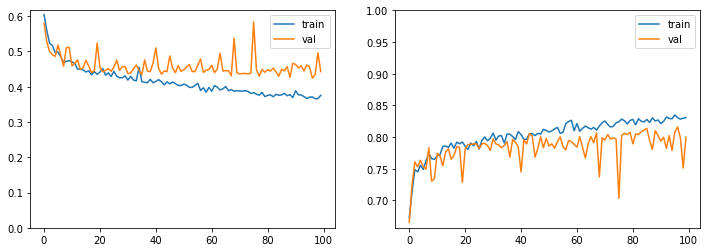

In [19]:
y = np.array([mrk.photo_reqs.flash_reflection_on_skin.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'flash_reflection_on_skin')
list_model_files.append(model_file)

#### 14. Red Eyes 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6456 - accuracy: 0.5477 - precision: 0.8857 - recall: 0.4833 - f1: 0.6033 - specificity: 0.7538 - negative_predictive_value: 0.2874 - matthews_correlation_coefficient: 0.2081 - val_loss: 0.6597 - val_accuracy: 0.4918 - val_precision: 0.8998 - val_recall: 0.3623 - val_f1: 0.5059 - val_specificity: 0.8762 - val_negative_predictive_value: 0.2903 - val_matthews_correlation_coefficient: 0.2379

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.23787, saving model to ../models/autoencoders_requirements/red_eyes_2020_03_28-21_53_42.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6245 - accuracy: 0.5521 - precision: 0.9008 - recall: 0.4699 - f1: 0.6016 - specificity: 0.8275 - negative_predictive_value: 0.3227 - matthews_correlation_coefficient: 0.2563 - val_loss: 0.6465 - val_accuracy: 0.5195 - val_precision: 0.


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.30410
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5700 - accuracy: 0.6566 - precision: 0.9097 - recall: 0.6224 - f1: 0.7299 - specificity: 0.7642 - negative_predictive_value: 0.3742 - matthews_correlation_coefficient: 0.3303 - val_loss: 0.6163 - val_accuracy: 0.6375 - val_precision: 0.8771 - val_recall: 0.5779 - val_f1: 0.6901 - val_specificity: 0.7627 - val_negative_predictive_value: 0.3564 - val_matthews_correlation_coefficient: 0.3083

Epoch 00015: val_matthews_correlation_coefficient improved from 0.30410 to 0.30832, saving model to ../models/autoencoders_requirements/red_eyes_2020_03_28-21_53_42.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5669 - accuracy: 0.6625 - precision: 0.9051 - recall: 0.6335 - f1: 0.7368 - specificity: 0.7587 - negative_predictive_value: 0.3828 - matthews_correlation_coefficient: 0.3349 - val_loss: 0.6842 - val

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5493 - accuracy: 0.6883 - precision: 0.9116 - recall: 0.6697 - f1: 0.7624 - specificity: 0.7728 - negative_predictive_value: 0.4151 - matthews_correlation_coefficient: 0.3761 - val_loss: 0.7642 - val_accuracy: 0.5594 - val_precision: 0.8984 - val_recall: 0.4560 - val_f1: 0.5956 - val_specificity: 0.8386 - val_negative_predictive_value: 0.3166 - val_matthews_correlation_coefficient: 0.2772

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.32515
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5436 - accuracy: 0.6941 - precision: 0.9071 - recall: 0.6800 - f1: 0.7689 - specificity: 0.7554 - negative_predictive_value: 0.4148 - matthews_correlation_coefficient: 0.3713 - val_loss: 0.5306 - val_accuracy: 0.7173 - val_precision: 0.8667 - val_recall: 0.7047 - val_f1: 0.7730 - val_specificity: 0.6783 - val_negative_predictive_value: 0.4182 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.35720
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5238 - accuracy: 0.7145 - precision: 0.9153 - recall: 0.7018 - f1: 0.7865 - specificity: 0.7698 - negative_predictive_value: 0.4405 - matthews_correlation_coefficient: 0.4061 - val_loss: 0.5862 - val_accuracy: 0.6539 - val_precision: 0.8902 - val_recall: 0.5915 - val_f1: 0.7043 - val_specificity: 0.7793 - val_negative_predictive_value: 0.3683 - val_matthews_correlation_coefficient: 0.3356

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.35720
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5161 - accuracy: 0.7156 - precision: 0.9149 - recall: 0.6978 - f1: 0.7854 - specificity: 0.7589 - negative_predictive_value: 0.4328 - matthews_correlation_coefficient: 0.3974 - val_loss: 0.5259 - val_accuracy: 0.7155 - val_precision: 0.8669 - val_recall: 0.7003 - val_f1: 0.7717 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.35720
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5096 - accuracy: 0.7091 - precision: 0.9178 - recall: 0.6872 - f1: 0.7784 - specificity: 0.7830 - negative_predictive_value: 0.4298 - matthews_correlation_coefficient: 0.4017 - val_loss: 0.6303 - val_accuracy: 0.6279 - val_precision: 0.9058 - val_recall: 0.5456 - val_f1: 0.6711 - val_specificity: 0.8276 - val_negative_predictive_value: 0.3570 - val_matthews_correlation_coefficient: 0.3388

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.35720
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5125 - accuracy: 0.7182 - precision: 0.9175 - recall: 0.7003 - f1: 0.7865 - specificity: 0.7683 - negative_predictive_value: 0.4389 - matthews_correlation_coefficient: 0.4074 - val_loss: 0.5781 - val_accuracy: 0.6626 - val_precision: 0.8863 - val_recall: 0.6065 - val_f1: 0.7133 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.35720
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4952 - accuracy: 0.7341 - precision: 0.9175 - recall: 0.7209 - f1: 0.7999 - specificity: 0.7719 - negative_predictive_value: 0.4612 - matthews_correlation_coefficient: 0.4304 - val_loss: 0.5787 - val_accuracy: 0.6852 - val_precision: 0.8792 - val_recall: 0.6481 - val_f1: 0.7414 - val_specificity: 0.7313 - val_negative_predictive_value: 0.3866 - val_matthews_correlation_coefficient: 0.3436

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.35720
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4975 - accuracy: 0.7341 - precision: 0.9165 - recall: 0.7221 - f1: 0.8029 - specificity: 0.7737 - negative_predictive_value: 0.4564 - matthews_correlation_coefficient: 0.4278 - val_loss: 0.5783 - val_accuracy: 0.6635 - val_precision: 0.8932 - val_recall: 0.6036 - val_f1: 0.7139 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4920 - accuracy: 0.7345 - precision: 0.9257 - recall: 0.7141 - f1: 0.8013 - specificity: 0.7993 - negative_predictive_value: 0.4533 - matthews_correlation_coefficient: 0.4388 - val_loss: 0.5469 - val_accuracy: 0.7147 - val_precision: 0.8931 - val_recall: 0.6741 - val_f1: 0.7631 - val_specificity: 0.7616 - val_negative_predictive_value: 0.4239 - val_matthews_correlation_coefficient: 0.3978

Epoch 00088: val_matthews_correlation_coefficient improved from 0.36002 to 0.39783, saving model to ../models/autoencoders_requirements/red_eyes_2020_03_28-21_53_42.h5
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4777 - accuracy: 0.7414 - precision: 0.9203 - recall: 0.7300 - f1: 0.8086 - specificity: 0.7760 - negative_predictive_value: 0.4632 - matthews_correlation_coefficient: 0.4378 - val_loss: 0.6831 - val_accuracy: 0.5906 - val_precision: 0.9092 - val_recall: 0.4904 - val_f1: 0.6290 - val_specifi

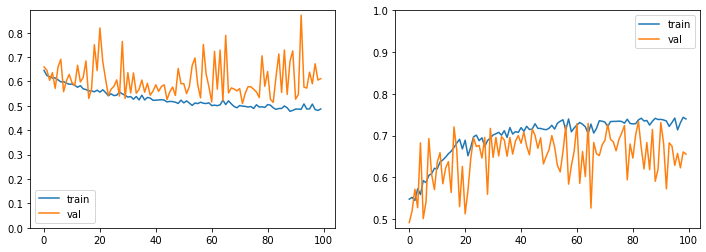

In [20]:
y = np.array([mrk.photo_reqs.red_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'red_eyes')
list_model_files.append(model_file)

#### 15. Shadows Behind Head 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.4498 - accuracy: 0.7657 - precision: 0.8640 - recall: 0.7463 - f1: 0.7926 - specificity: 0.8143 - negative_predictive_value: 0.6656 - matthews_correlation_coefficient: 0.5461 - val_loss: 0.4021 - val_accuracy: 0.7988 - val_precision: 0.8944 - val_recall: 0.7208 - val_f1: 0.7940 - val_specificity: 0.8985 - val_negative_predictive_value: 0.6897 - val_matthews_correlation_coefficient: 0.6005

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.60046, saving model to ../models/autoencoders_requirements/shadows_behind_head_2020_03_28-22_08_33.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3820 - accuracy: 0.8082 - precision: 0.8993 - recall: 0.7801 - f1: 0.8310 - specificity: 0.8635 - negative_predictive_value: 0.7100 - matthews_correlation_coefficient: 0.6255 - val_loss: 0.4744 - val_accuracy: 0.7493 - val_p


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.67763
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3220 - accuracy: 0.8495 - precision: 0.9240 - recall: 0.8271 - f1: 0.8693 - specificity: 0.8912 - negative_predictive_value: 0.7624 - matthews_correlation_coefficient: 0.7016 - val_loss: 0.3262 - val_accuracy: 0.8630 - val_precision: 0.9013 - val_recall: 0.8235 - val_f1: 0.8579 - val_specificity: 0.8905 - val_negative_predictive_value: 0.7846 - val_matthews_correlation_coefficient: 0.6991

Epoch 00015: val_matthews_correlation_coefficient improved from 0.67763 to 0.69909, saving model to ../models/autoencoders_requirements/shadows_behind_head_2020_03_28-22_08_33.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3187 - accuracy: 0.8497 - precision: 0.9214 - recall: 0.8294 - f1: 0.8696 - specificity: 0.8881 - negative_predictive_value: 0.7648 - matthews_correlation_coefficient: 0.7012 - val_loss: 0

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2988 - accuracy: 0.8692 - precision: 0.9285 - recall: 0.8565 - f1: 0.8866 - specificity: 0.8854 - negative_predictive_value: 0.7962 - matthews_correlation_coefficient: 0.7342 - val_loss: 0.3273 - val_accuracy: 0.8682 - val_precision: 0.8962 - val_recall: 0.8361 - val_f1: 0.8624 - val_specificity: 0.8901 - val_negative_predictive_value: 0.8000 - val_matthews_correlation_coefficient: 0.7102

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.71935
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2937 - accuracy: 0.8655 - precision: 0.9240 - recall: 0.8519 - f1: 0.8819 - specificity: 0.8849 - negative_predictive_value: 0.7892 - matthews_correlation_coefficient: 0.7260 - val_loss: 0.3102 - val_accuracy: 0.8760 - val_precision: 0.8526 - val_recall: 0.9051 - val_f1: 0.8755 - val_specificity: 0.7942 - val_negative_predictive_value: 0.8761 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2905 - accuracy: 0.8746 - precision: 0.9252 - recall: 0.8666 - f1: 0.8906 - specificity: 0.8893 - negative_predictive_value: 0.8017 - matthews_correlation_coefficient: 0.7425 - val_loss: 0.3284 - val_accuracy: 0.8534 - val_precision: 0.9089 - val_recall: 0.7979 - val_f1: 0.8463 - val_specificity: 0.9098 - val_negative_predictive_value: 0.7652 - val_matthews_correlation_coefficient: 0.6898

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.75187
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2829 - accuracy: 0.8774 - precision: 0.9333 - recall: 0.8663 - f1: 0.8951 - specificity: 0.9049 - negative_predictive_value: 0.8073 - matthews_correlation_coefficient: 0.7550 - val_loss: 0.3121 - val_accuracy: 0.8716 - val_precision: 0.9094 - val_recall: 0.8293 - val_f1: 0.8643 - val_specificity: 0.9104 - val_negative_predictive_value: 0.7966 - val_matthews_correlation_coefficie


Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.76322
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2632 - accuracy: 0.8924 - precision: 0.9327 - recall: 0.8923 - f1: 0.9091 - specificity: 0.8910 - negative_predictive_value: 0.8351 - matthews_correlation_coefficient: 0.7749 - val_loss: 0.3314 - val_accuracy: 0.8612 - val_precision: 0.9177 - val_recall: 0.8016 - val_f1: 0.8530 - val_specificity: 0.9247 - val_negative_predictive_value: 0.7701 - val_matthews_correlation_coefficient: 0.7060

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.76322
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2694 - accuracy: 0.8852 - precision: 0.9286 - recall: 0.8793 - f1: 0.8996 - specificity: 0.8848 - negative_predictive_value: 0.8238 - matthews_correlation_coefficient: 0.7593 - val_loss: 0.2873 - val_accuracy: 0.8907 - val_precision: 0.8717 - val_recall: 0.9037 - val_f1: 0.8855 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2488 - accuracy: 0.8991 - precision: 0.9356 - recall: 0.8964 - f1: 0.9126 - specificity: 0.8957 - negative_predictive_value: 0.8439 - matthews_correlation_coefficient: 0.7870 - val_loss: 0.2858 - val_accuracy: 0.8916 - val_precision: 0.9030 - val_recall: 0.8698 - val_f1: 0.8838 - val_specificity: 0.8954 - val_negative_predictive_value: 0.8391 - val_matthews_correlation_coefficient: 0.7530

Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.78089
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2518 - accuracy: 0.8985 - precision: 0.9333 - recall: 0.9013 - f1: 0.9139 - specificity: 0.8961 - negative_predictive_value: 0.8450 - matthews_correlation_coefficient: 0.7872 - val_loss: 0.2902 - val_accuracy: 0.8864 - val_precision: 0.8831 - val_recall: 0.8856 - val_f1: 0.8825 - val_specificity: 0.8522 - val_negative_predictive_value: 0.8492 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2429 - accuracy: 0.8967 - precision: 0.9312 - recall: 0.9003 - f1: 0.9126 - specificity: 0.8902 - negative_predictive_value: 0.8537 - matthews_correlation_coefficient: 0.7870 - val_loss: 0.2864 - val_accuracy: 0.8864 - val_precision: 0.9050 - val_recall: 0.8575 - val_f1: 0.8786 - val_specificity: 0.8997 - val_negative_predictive_value: 0.8262 - val_matthews_correlation_coefficient: 0.7434

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.78089
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2355 - accuracy: 0.9007 - precision: 0.9317 - recall: 0.9027 - f1: 0.9135 - specificity: 0.8974 - negative_predictive_value: 0.8453 - matthews_correlation_coefficient: 0.7895 - val_loss: 0.2778 - val_accuracy: 0.8916 - val_precision: 0.9126 - val_recall: 0.8596 - val_f1: 0.8828 - val_specificity: 0.9127 - val_negative_predictive_value: 0.8313 - val_matthews_correlation_coefficie

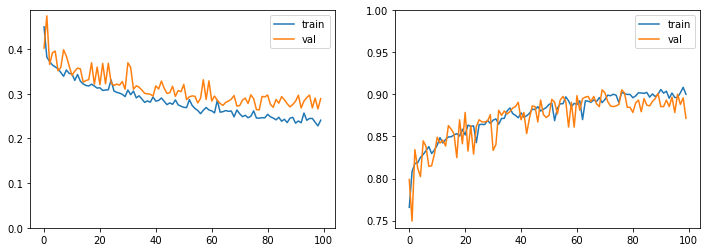

In [21]:
y = np.array([mrk.photo_reqs.shadows_behind_head.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'shadows_behind_head')
list_model_files.append(model_file)

#### 16. Shadows Across Face

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6062 - accuracy: 0.6497 - precision: 0.6785 - recall: 0.6211 - f1: 0.6282 - specificity: 0.6762 - negative_predictive_value: 0.6344 - matthews_correlation_coefficient: 0.3060 - val_loss: 0.5805 - val_accuracy: 0.6670 - val_precision: 0.7158 - val_recall: 0.6262 - val_f1: 0.6566 - val_specificity: 0.7051 - val_negative_predictive_value: 0.6238 - val_matthews_correlation_coefficient: 0.3350

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.33501, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_28-22_23_29.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5801 - accuracy: 0.6835 - precision: 0.6927 - recall: 0.7077 - f1: 0.6875 - specificity: 0.6532 - negative_predictive_value: 0.6820 - matthews_correlation_coefficient: 0.3742 - val_loss: 0.5572 - val_accuracy: 0.7025 - val_p


Epoch 00014: val_matthews_correlation_coefficient improved from 0.47764 to 0.48861, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_28-22_23_29.h5
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5113 - accuracy: 0.7421 - precision: 0.7367 - recall: 0.7711 - f1: 0.7461 - specificity: 0.7132 - negative_predictive_value: 0.7527 - matthews_correlation_coefficient: 0.4867 - val_loss: 0.5067 - val_accuracy: 0.7285 - val_precision: 0.7777 - val_recall: 0.6931 - val_f1: 0.7245 - val_specificity: 0.7557 - val_negative_predictive_value: 0.6733 - val_matthews_correlation_coefficient: 0.4495

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.48861
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5060 - accuracy: 0.7536 - precision: 0.7620 - recall: 0.7794 - f1: 0.7617 - specificity: 0.7307 - negative_predictive_value: 0.7513 - matthews_correlation_coefficient: 0.5113 - val_loss: 0

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4769 - accuracy: 0.7748 - precision: 0.7739 - recall: 0.8091 - f1: 0.7850 - specificity: 0.7480 - negative_predictive_value: 0.7824 - matthews_correlation_coefficient: 0.5564 - val_loss: 0.4759 - val_accuracy: 0.7537 - val_precision: 0.7822 - val_recall: 0.7485 - val_f1: 0.7594 - val_specificity: 0.7496 - val_negative_predictive_value: 0.7085 - val_matthews_correlation_coefficient: 0.4942

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.52151
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4675 - accuracy: 0.7753 - precision: 0.7699 - recall: 0.8030 - f1: 0.7799 - specificity: 0.7429 - negative_predictive_value: 0.7766 - matthews_correlation_coefficient: 0.5476 - val_loss: 0.4791 - val_accuracy: 0.7589 - val_precision: 0.7133 - val_recall: 0.9177 - val_f1: 0.7980 - val_specificity: 0.5725 - val_negative_predictive_value: 0.8405 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4413 - accuracy: 0.7909 - precision: 0.7887 - recall: 0.8160 - f1: 0.7976 - specificity: 0.7654 - negative_predictive_value: 0.7964 - matthews_correlation_coefficient: 0.5831 - val_loss: 0.4975 - val_accuracy: 0.7450 - val_precision: 0.7591 - val_recall: 0.7649 - val_f1: 0.7570 - val_specificity: 0.7109 - val_negative_predictive_value: 0.7113 - val_matthews_correlation_coefficient: 0.4730

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.55436
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4486 - accuracy: 0.7839 - precision: 0.7822 - recall: 0.7958 - f1: 0.7816 - specificity: 0.7624 - negative_predictive_value: 0.7813 - matthews_correlation_coefficient: 0.5606 - val_loss: 0.4686 - val_accuracy: 0.7650 - val_precision: 0.7219 - val_recall: 0.9056 - val_f1: 0.7992 - val_specificity: 0.5978 - val_negative_predictive_value: 0.8300 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4414 - accuracy: 0.7928 - precision: 0.7841 - recall: 0.8209 - f1: 0.7944 - specificity: 0.7541 - negative_predictive_value: 0.8003 - matthews_correlation_coefficient: 0.5860 - val_loss: 0.4754 - val_accuracy: 0.7563 - val_precision: 0.7862 - val_recall: 0.7502 - val_f1: 0.7606 - val_specificity: 0.7573 - val_negative_predictive_value: 0.7144 - val_matthews_correlation_coefficient: 0.5038

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.55436
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4416 - accuracy: 0.7920 - precision: 0.7875 - recall: 0.8129 - f1: 0.7922 - specificity: 0.7658 - negative_predictive_value: 0.7958 - matthews_correlation_coefficient: 0.5806 - val_loss: 0.4791 - val_accuracy: 0.7493 - val_precision: 0.7898 - val_recall: 0.7239 - val_f1: 0.7501 - val_specificity: 0.7677 - val_negative_predictive_value: 0.6955 - val_matthews_correlation_coefficie


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.56160
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4338 - accuracy: 0.7928 - precision: 0.7921 - recall: 0.8215 - f1: 0.7986 - specificity: 0.7616 - negative_predictive_value: 0.8003 - matthews_correlation_coefficient: 0.5873 - val_loss: 0.4686 - val_accuracy: 0.7710 - val_precision: 0.7513 - val_recall: 0.8484 - val_f1: 0.7926 - val_specificity: 0.6704 - val_negative_predictive_value: 0.7786 - val_matthews_correlation_coefficient: 0.5240

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.56160
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4322 - accuracy: 0.7963 - precision: 0.7894 - recall: 0.8355 - f1: 0.8047 - specificity: 0.7644 - negative_predictive_value: 0.8143 - matthews_correlation_coefficient: 0.6016 - val_loss: 0.4819 - val_accuracy: 0.7459 - val_precision: 0.7796 - val_recall: 0.7314 - val_f1: 0.7474 - val_spe


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.56160
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4199 - accuracy: 0.8028 - precision: 0.7998 - recall: 0.8349 - f1: 0.8097 - specificity: 0.7790 - negative_predictive_value: 0.8114 - matthews_correlation_coefficient: 0.6122 - val_loss: 0.4508 - val_accuracy: 0.7892 - val_precision: 0.7590 - val_recall: 0.8875 - val_f1: 0.8138 - val_specificity: 0.6675 - val_negative_predictive_value: 0.8215 - val_matthews_correlation_coefficient: 0.5665

Epoch 00088: val_matthews_correlation_coefficient improved from 0.56160 to 0.56649, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_28-22_23_29.h5
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4128 - accuracy: 0.8080 - precision: 0.8014 - recall: 0.8238 - f1: 0.8063 - specificity: 0.7896 - negative_predictive_value: 0.8100 - matthews_correlation_coefficient: 0.6138 - val_loss: 0

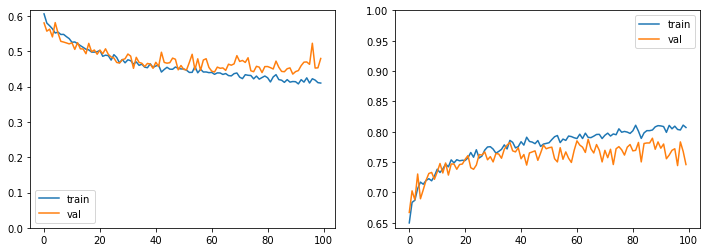

In [22]:
y = np.array([mrk.photo_reqs.shadows_across_face.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'shadows_across_face')
list_model_files.append(model_file)

#### 17. Dark Tinted Lenses

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5830 - accuracy: 0.5458 - precision: 0.9671 - recall: 0.5119 - f1: 0.6608 - specificity: 0.8452 - negative_predictive_value: 0.1871 - matthews_correlation_coefficient: 0.2306 - val_loss: 0.7048 - val_accuracy: 0.4449 - val_precision: 0.9574 - val_recall: 0.3691 - val_f1: 0.5279 - val_specificity: 0.9379 - val_negative_predictive_value: 0.1836 - val_matthews_correlation_coefficient: 0.2068

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.20684, saving model to ../models/autoencoders_requirements/dark_tinted_lenses_2020_03_28-22_38_23.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5708 - accuracy: 0.5312 - precision: 0.9668 - recall: 0.4917 - f1: 0.6395 - specificity: 0.8195 - negative_predictive_value: 0.1817 - matthews_correlation_coefficient: 0.2116 - val_loss: 0.5429 - val_accuracy: 0.5776 - val_pr


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.35677
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4661 - accuracy: 0.7297 - precision: 0.9715 - recall: 0.7183 - f1: 0.8174 - specificity: 0.8122 - negative_predictive_value: 0.2876 - matthews_correlation_coefficient: 0.3619 - val_loss: 0.7969 - val_accuracy: 0.5473 - val_precision: 0.9569 - val_recall: 0.4847 - val_f1: 0.6385 - val_specificity: 0.8763 - val_negative_predictive_value: 0.1857 - val_matthews_correlation_coefficient: 0.2545

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.35677
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4535 - accuracy: 0.7317 - precision: 0.9730 - recall: 0.7216 - f1: 0.8221 - specificity: 0.8225 - negative_predictive_value: 0.2920 - matthews_correlation_coefficient: 0.3687 - val_loss: 0.3735 - val_accuracy: 0.8222 - val_precision: 0.9289 - val_recall: 0.8183 - val_f1: 0.8683 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4038 - accuracy: 0.7610 - precision: 0.9750 - recall: 0.7499 - f1: 0.8394 - specificity: 0.8199 - negative_predictive_value: 0.3184 - matthews_correlation_coefficient: 0.4014 - val_loss: 0.3795 - val_accuracy: 0.7892 - val_precision: 0.9507 - val_recall: 0.7609 - val_f1: 0.8425 - val_specificity: 0.7880 - val_negative_predictive_value: 0.3231 - val_matthews_correlation_coefficient: 0.4079

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.40862
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4321 - accuracy: 0.7479 - precision: 0.9733 - recall: 0.7410 - f1: 0.8321 - specificity: 0.8129 - negative_predictive_value: 0.3107 - matthews_correlation_coefficient: 0.3873 - val_loss: 0.6822 - val_accuracy: 0.6088 - val_precision: 0.9615 - val_recall: 0.5504 - val_f1: 0.6957 - val_specificity: 0.9035 - val_negative_predictive_value: 0.2361 - val_matthews_correlation_coefficie


Epoch 00042: val_matthews_correlation_coefficient did not improve from 0.43447
Epoch 43/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3622 - accuracy: 0.7924 - precision: 0.9814 - recall: 0.7801 - f1: 0.8655 - specificity: 0.8503 - negative_predictive_value: 0.3478 - matthews_correlation_coefficient: 0.4504 - val_loss: 0.4910 - val_accuracy: 0.7225 - val_precision: 0.9637 - val_recall: 0.6755 - val_f1: 0.7913 - val_specificity: 0.9276 - val_negative_predictive_value: 0.2994 - val_matthews_correlation_coefficient: 0.3895

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.43447
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3853 - accuracy: 0.7822 - precision: 0.9783 - recall: 0.7724 - f1: 0.8577 - specificity: 0.8367 - negative_predictive_value: 0.3421 - matthews_correlation_coefficient: 0.4333 - val_loss: 0.5760 - val_accuracy: 0.6756 - val_precision: 0.9646 - val_recall: 0.6230 - val_f1: 0.7533 - val_spe


Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.43447
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3528 - accuracy: 0.8007 - precision: 0.9773 - recall: 0.7942 - f1: 0.8718 - specificity: 0.8347 - negative_predictive_value: 0.3568 - matthews_correlation_coefficient: 0.4546 - val_loss: 0.5079 - val_accuracy: 0.7121 - val_precision: 0.9638 - val_recall: 0.6640 - val_f1: 0.7828 - val_specificity: 0.9298 - val_negative_predictive_value: 0.2932 - val_matthews_correlation_coefficient: 0.3822

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.43447
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3576 - accuracy: 0.7989 - precision: 0.9805 - recall: 0.7884 - f1: 0.8682 - specificity: 0.8554 - negative_predictive_value: 0.3753 - matthews_correlation_coefficient: 0.4672 - val_loss: 0.5817 - val_accuracy: 0.6774 - val_precision: 0.9692 - val_recall: 0.6223 - val_f1: 0.7539 - val_spe

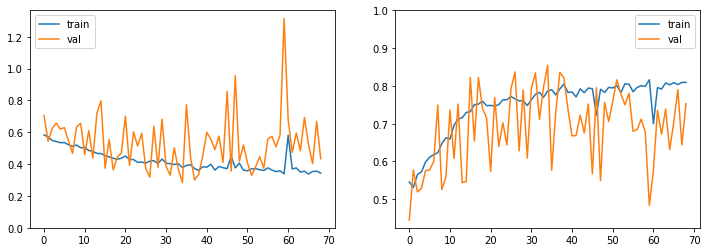

In [23]:
y = np.array([mrk.photo_reqs.dark_tinted_lenses.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'dark_tinted_lenses')
list_model_files.append(model_file)

#### 18. Flash Reflection on Lenses

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5798 - accuracy: 0.6377 - precision: 0.9121 - recall: 0.6075 - f1: 0.7184 - specificity: 0.7578 - negative_predictive_value: 0.3358 - matthews_correlation_coefficient: 0.3016 - val_loss: 0.5576 - val_accuracy: 0.7372 - val_precision: 0.8784 - val_recall: 0.7851 - val_f1: 0.8264 - val_specificity: 0.5421 - val_negative_predictive_value: 0.3913 - val_matthews_correlation_coefficient: 0.2953

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.29534, saving model to ../models/autoencoders_requirements/flash_reflection_on_lenses_2020_03_28-22_48_48.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5723 - accuracy: 0.6811 - precision: 0.9047 - recall: 0.6716 - f1: 0.7632 - specificity: 0.7381 - negative_predictive_value: 0.3750 - matthews_correlation_coefficient: 0.3348 - val_loss: 0.7093 - val_accuracy: 0.5447 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5250 - accuracy: 0.7182 - precision: 0.9166 - recall: 0.7100 - f1: 0.7946 - specificity: 0.7579 - negative_predictive_value: 0.4075 - matthews_correlation_coefficient: 0.3864 - val_loss: 0.5783 - val_accuracy: 0.5906 - val_precision: 0.9439 - val_recall: 0.5285 - val_f1: 0.6701 - val_specificity: 0.8520 - val_negative_predictive_value: 0.3157 - val_matthews_correlation_coefficient: 0.3128

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.33217
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5243 - accuracy: 0.7054 - precision: 0.9205 - recall: 0.6926 - f1: 0.7822 - specificity: 0.7653 - negative_predictive_value: 0.4051 - matthews_correlation_coefficient: 0.3826 - val_loss: 0.5557 - val_accuracy: 0.6704 - val_precision: 0.9133 - val_recall: 0.6561 - val_f1: 0.7596 - val_specificity: 0.7387 - val_negative_predictive_value: 0.3557 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient improved from 0.35686 to 0.36861, saving model to ../models/autoencoders_requirements/flash_reflection_on_lenses_2020_03_28-22_48_48.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4885 - accuracy: 0.7403 - precision: 0.9269 - recall: 0.7308 - f1: 0.8113 - specificity: 0.7756 - negative_predictive_value: 0.4389 - matthews_correlation_coefficient: 0.4273 - val_loss: 0.5706 - val_accuracy: 0.6383 - val_precision: 0.9405 - val_recall: 0.5934 - val_f1: 0.7225 - val_specificity: 0.8304 - val_negative_predictive_value: 0.3411 - val_matthews_correlation_coefficient: 0.3440

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.36861
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5055 - accuracy: 0.7252 - precision: 0.9233 - recall: 0.7142 - f1: 0.7987 - specificity: 0.7664 - negative_predictive_value: 0.4238 - matthews_correlation_coefficient: 0.4045 - val_

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4766 - accuracy: 0.7510 - precision: 0.9284 - recall: 0.7449 - f1: 0.8193 - specificity: 0.7754 - negative_predictive_value: 0.4598 - matthews_correlation_coefficient: 0.4472 - val_loss: 0.6918 - val_accuracy: 0.6323 - val_precision: 0.9527 - val_recall: 0.5762 - val_f1: 0.7131 - val_specificity: 0.8674 - val_negative_predictive_value: 0.3413 - val_matthews_correlation_coefficient: 0.3594

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.37036
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4709 - accuracy: 0.7551 - precision: 0.9344 - recall: 0.7451 - f1: 0.8240 - specificity: 0.7715 - negative_predictive_value: 0.4485 - matthews_correlation_coefficient: 0.4438 - val_loss: 0.5632 - val_accuracy: 0.6383 - val_precision: 0.9291 - val_recall: 0.6018 - val_f1: 0.7253 - val_specificity: 0.7973 - val_negative_predictive_value: 0.3361 - val_matthews_correlation_coefficie


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.39214
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4674 - accuracy: 0.7505 - precision: 0.9310 - recall: 0.7421 - f1: 0.8199 - specificity: 0.7840 - negative_predictive_value: 0.4589 - matthews_correlation_coefficient: 0.4492 - val_loss: 0.6154 - val_accuracy: 0.6019 - val_precision: 0.9458 - val_recall: 0.5430 - val_f1: 0.6816 - val_specificity: 0.8530 - val_negative_predictive_value: 0.3244 - val_matthews_correlation_coefficient: 0.3258

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.39214
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4523 - accuracy: 0.7586 - precision: 0.9229 - recall: 0.7500 - f1: 0.8221 - specificity: 0.7776 - negative_predictive_value: 0.4635 - matthews_correlation_coefficient: 0.4495 - val_loss: 0.6088 - val_accuracy: 0.6444 - val_precision: 0.9471 - val_recall: 0.5953 - val_f1: 0.7252 - val_spe


Epoch 00073: val_matthews_correlation_coefficient improved from 0.39214 to 0.39787, saving model to ../models/autoencoders_requirements/flash_reflection_on_lenses_2020_03_28-22_48_48.h5
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4434 - accuracy: 0.7746 - precision: 0.9342 - recall: 0.7703 - f1: 0.8388 - specificity: 0.7855 - negative_predictive_value: 0.4864 - matthews_correlation_coefficient: 0.4784 - val_loss: 0.6312 - val_accuracy: 0.6262 - val_precision: 0.9401 - val_recall: 0.5780 - val_f1: 0.7107 - val_specificity: 0.8310 - val_negative_predictive_value: 0.3336 - val_matthews_correlation_coefficient: 0.3334

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.39787
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4405 - accuracy: 0.7766 - precision: 0.9400 - recall: 0.7704 - f1: 0.8424 - specificity: 0.8058 - negative_predictive_value: 0.4848 - matthews_correlation_coefficient: 0.4912 - val_

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4293 - accuracy: 0.7751 - precision: 0.9406 - recall: 0.7641 - f1: 0.8370 - specificity: 0.8007 - negative_predictive_value: 0.4875 - matthews_correlation_coefficient: 0.4906 - val_loss: 0.6551 - val_accuracy: 0.6574 - val_precision: 0.9427 - val_recall: 0.6173 - val_f1: 0.7418 - val_specificity: 0.8243 - val_negative_predictive_value: 0.3494 - val_matthews_correlation_coefficient: 0.3576

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.40129
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4345 - accuracy: 0.7666 - precision: 0.9354 - recall: 0.7619 - f1: 0.8339 - specificity: 0.7959 - negative_predictive_value: 0.4742 - matthews_correlation_coefficient: 0.4726 - val_loss: 0.5972 - val_accuracy: 0.6435 - val_precision: 0.9391 - val_recall: 0.6012 - val_f1: 0.7269 - val_specificity: 0.8238 - val_negative_predictive_value: 0.3469 - val_matthews_correlation_coefficie

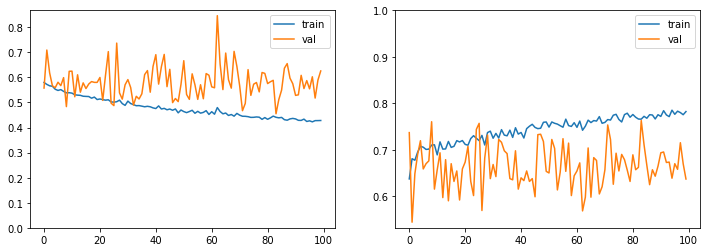

In [24]:
y = np.array([mrk.photo_reqs.flash_reflection_on_lenses.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'flash_reflection_on_lenses')
list_model_files.append(model_file)

#### 19. Frames Too Heavy

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5681 - accuracy: 0.8458 - precision: 0.9984 - recall: 0.8478 - f1: 0.9088 - specificity: 0.0621 - negative_predictive_value: 0.0149 - matthews_correlation_coefficient: 0.0238 - val_loss: 0.0466 - val_accuracy: 0.9965 - val_precision: 0.9966 - val_recall: 1.0000 - val_f1: 0.9983 - val_specificity: 0.0000e+00 - val_negative_predictive_value: 0.0000e+00 - val_matthews_correlation_coefficient: 0.0000e+00

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.00000, saving model to ../models/autoencoders_requirements/frames_too_heavy_2020_03_28-23_03_50.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5937 - accuracy: 0.6807 - precision: 0.9989 - recall: 0.6831 - f1: 0.7893 - specificity: 0.0759 - negative_predictive_value: 0.0139 - matthews_correlation_coefficient: 0.0235 - val_loss: 0.3448 - val_accuracy: 0.802

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2308 - accuracy: 0.8612 - precision: 1.0000 - recall: 0.8586 - f1: 0.9219 - specificity: 0.0966 - negative_predictive_value: 0.0397 - matthews_correlation_coefficient: 0.0562 - val_loss: 0.2174 - val_accuracy: 0.8951 - val_precision: 1.0000 - val_recall: 0.8974 - val_f1: 0.9450 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0302 - val_matthews_correlation_coefficient: 0.0530

Epoch 00015: val_matthews_correlation_coefficient improved from 0.04649 to 0.05303, saving model to ../models/autoencoders_requirements/frames_too_heavy_2020_03_28-23_03_50.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2035 - accuracy: 0.8829 - precision: 1.0000 - recall: 0.8799 - f1: 0.9336 - specificity: 0.1103 - negative_predictive_value: 0.0315 - matthews_correlation_coefficient: 0.0535 - val_loss: 0.3231 - val_accuracy: 0.8526 - val_precision: 1.0000 - val_recall: 0.8558 - val_f1: 0.9206 - val

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1952 - accuracy: 0.8918 - precision: 0.9998 - recall: 0.8923 - f1: 0.9412 - specificity: 0.1034 - negative_predictive_value: 0.0358 - matthews_correlation_coefficient: 0.0549 - val_loss: 0.3063 - val_accuracy: 0.8820 - val_precision: 1.0000 - val_recall: 0.8848 - val_f1: 0.9378 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0266 - val_matthews_correlation_coefficient: 0.0505

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.07520
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1543 - accuracy: 0.9072 - precision: 1.0000 - recall: 0.9075 - f1: 0.9505 - specificity: 0.1034 - negative_predictive_value: 0.0370 - matthews_correlation_coefficient: 0.0580 - val_loss: 0.0974 - val_accuracy: 0.9532 - val_precision: 1.0000 - val_recall: 0.9543 - val_f1: 0.9762 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0676 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.08343
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4295 - accuracy: 0.8670 - precision: 0.9993 - recall: 0.8681 - f1: 0.9205 - specificity: 0.0897 - negative_predictive_value: 0.0256 - matthews_correlation_coefficient: 0.0425 - val_loss: 0.0548 - val_accuracy: 0.9775 - val_precision: 0.9983 - val_recall: 0.9797 - val_f1: 0.9887 - val_specificity: 0.0541 - val_negative_predictive_value: 0.0270 - val_matthews_correlation_coefficient: 0.0376

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.08343
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2009 - accuracy: 0.8989 - precision: 0.9998 - recall: 0.8994 - f1: 0.9457 - specificity: 0.1034 - negative_predictive_value: 0.0285 - matthews_correlation_coefficient: 0.0490 - val_loss: 0.1562 - val_accuracy: 0.9462 - val_precision: 0.9992 - val_recall: 0.9483 - val_f1: 0.9725 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.08343
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3158 - accuracy: 0.9408 - precision: 0.9998 - recall: 0.9412 - f1: 0.9688 - specificity: 0.1034 - negative_predictive_value: 0.0478 - matthews_correlation_coefficient: 0.0662 - val_loss: 0.4242 - val_accuracy: 0.8526 - val_precision: 1.0000 - val_recall: 0.8560 - val_f1: 0.9210 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0228 - val_matthews_correlation_coefficient: 0.0457

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.08343
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1649 - accuracy: 0.8980 - precision: 1.0000 - recall: 0.8982 - f1: 0.9448 - specificity: 0.1103 - negative_predictive_value: 0.0303 - matthews_correlation_coefficient: 0.0518 - val_loss: 0.2917 - val_accuracy: 0.8812 - val_precision: 1.0000 - val_recall: 0.8839 - val_f1: 0.9373 - val_spe

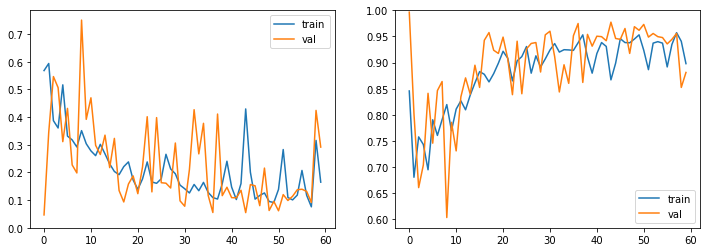

In [25]:
y = np.array([mrk.photo_reqs.frames_too_heavy.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'frames_too_heavy')
list_model_files.append(model_file)

#### 20. Frame Covering Eyes  

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6037 - accuracy: 0.6249 - precision: 0.8719 - recall: 0.5604 - f1: 0.6668 - specificity: 0.7862 - negative_predictive_value: 0.4230 - matthews_correlation_coefficient: 0.3249 - val_loss: 0.5895 - val_accuracy: 0.6548 - val_precision: 0.8083 - val_recall: 0.6240 - val_f1: 0.6982 - val_specificity: 0.6768 - val_negative_predictive_value: 0.4416 - val_matthews_correlation_coefficient: 0.3001

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.30008, saving model to ../models/autoencoders_requirements/frame_covering_eyes_2020_03_28-23_12_52.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5913 - accuracy: 0.6401 - precision: 0.8793 - recall: 0.5634 - f1: 0.6743 - specificity: 0.8134 - negative_predictive_value: 0.4494 - matthews_correlation_coefficient: 0.3571 - val_loss: 0.6763 - val_accuracy: 0.5507 - val_p


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.39528
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5515 - accuracy: 0.6846 - precision: 0.9044 - recall: 0.6220 - f1: 0.7288 - specificity: 0.8394 - negative_predictive_value: 0.4826 - matthews_correlation_coefficient: 0.4216 - val_loss: 0.5991 - val_accuracy: 0.6236 - val_precision: 0.9002 - val_recall: 0.4872 - val_f1: 0.6258 - val_specificity: 0.8794 - val_negative_predictive_value: 0.4241 - val_matthews_correlation_coefficient: 0.3692

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.39528
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5512 - accuracy: 0.6766 - precision: 0.8984 - recall: 0.6042 - f1: 0.7134 - specificity: 0.8436 - negative_predictive_value: 0.4812 - matthews_correlation_coefficient: 0.4175 - val_loss: 0.5764 - val_accuracy: 0.6574 - val_precision: 0.8858 - val_recall: 0.5500 - val_f1: 0.6730 - val_spe


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.42178
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5140 - accuracy: 0.7098 - precision: 0.9152 - recall: 0.6473 - f1: 0.7522 - specificity: 0.8572 - negative_predictive_value: 0.5107 - matthews_correlation_coefficient: 0.4637 - val_loss: 0.5035 - val_accuracy: 0.7103 - val_precision: 0.8332 - val_recall: 0.6844 - val_f1: 0.7476 - val_specificity: 0.7067 - val_negative_predictive_value: 0.4953 - val_matthews_correlation_coefficient: 0.3845

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.42178
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5137 - accuracy: 0.7098 - precision: 0.9135 - recall: 0.6532 - f1: 0.7559 - specificity: 0.8549 - negative_predictive_value: 0.5134 - matthews_correlation_coefficient: 0.4634 - val_loss: 0.4942 - val_accuracy: 0.7251 - val_precision: 0.8499 - val_recall: 0.6922 - val_f1: 0.7585 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5028 - accuracy: 0.7230 - precision: 0.9166 - recall: 0.6720 - f1: 0.7688 - specificity: 0.8418 - negative_predictive_value: 0.5225 - matthews_correlation_coefficient: 0.4734 - val_loss: 0.4960 - val_accuracy: 0.7199 - val_precision: 0.8418 - val_recall: 0.6916 - val_f1: 0.7556 - val_specificity: 0.7210 - val_negative_predictive_value: 0.5048 - val_matthews_correlation_coefficient: 0.4041

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.43212
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5008 - accuracy: 0.7241 - precision: 0.9128 - recall: 0.6748 - f1: 0.7703 - specificity: 0.8461 - negative_predictive_value: 0.5280 - matthews_correlation_coefficient: 0.4773 - val_loss: 0.5153 - val_accuracy: 0.7207 - val_precision: 0.8812 - val_recall: 0.6543 - val_f1: 0.7468 - val_specificity: 0.8081 - val_negative_predictive_value: 0.5062 - val_matthews_correlation_coefficie


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.44873
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4892 - accuracy: 0.7275 - precision: 0.9193 - recall: 0.6721 - f1: 0.7718 - specificity: 0.8608 - negative_predictive_value: 0.5275 - matthews_correlation_coefficient: 0.4866 - val_loss: 0.4945 - val_accuracy: 0.7268 - val_precision: 0.8656 - val_recall: 0.6769 - val_f1: 0.7561 - val_specificity: 0.7772 - val_negative_predictive_value: 0.5131 - val_matthews_correlation_coefficient: 0.4404

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.44873
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4813 - accuracy: 0.7269 - precision: 0.9086 - recall: 0.6786 - f1: 0.7723 - specificity: 0.8348 - negative_predictive_value: 0.5271 - matthews_correlation_coefficient: 0.4734 - val_loss: 0.5365 - val_accuracy: 0.6982 - val_precision: 0.8943 - val_recall: 0.6088 - val_f1: 0.7187 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.45150
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4788 - accuracy: 0.7360 - precision: 0.9156 - recall: 0.6890 - f1: 0.7811 - specificity: 0.8540 - negative_predictive_value: 0.5430 - matthews_correlation_coefficient: 0.4973 - val_loss: 0.5049 - val_accuracy: 0.7268 - val_precision: 0.8641 - val_recall: 0.6794 - val_f1: 0.7578 - val_specificity: 0.7678 - val_negative_predictive_value: 0.5108 - val_matthews_correlation_coefficient: 0.4352

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.45150
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4737 - accuracy: 0.7360 - precision: 0.9156 - recall: 0.6892 - f1: 0.7808 - specificity: 0.8459 - negative_predictive_value: 0.5371 - matthews_correlation_coefficient: 0.4921 - val_loss: 0.5266 - val_accuracy: 0.7112 - val_precision: 0.8959 - val_recall: 0.6295 - val_f1: 0.7350 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4747 - accuracy: 0.7356 - precision: 0.9127 - recall: 0.6812 - f1: 0.7733 - specificity: 0.8580 - negative_predictive_value: 0.5469 - matthews_correlation_coefficient: 0.4969 - val_loss: 0.6130 - val_accuracy: 0.6652 - val_precision: 0.9418 - val_recall: 0.5677 - val_f1: 0.7001 - val_specificity: 0.8864 - val_negative_predictive_value: 0.4546 - val_matthews_correlation_coefficient: 0.4216

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.47069
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4795 - accuracy: 0.7328 - precision: 0.9159 - recall: 0.6845 - f1: 0.7776 - specificity: 0.8445 - negative_predictive_value: 0.5326 - matthews_correlation_coefficient: 0.4864 - val_loss: 0.4972 - val_accuracy: 0.7242 - val_precision: 0.8660 - val_recall: 0.6723 - val_f1: 0.7537 - val_specificity: 0.7746 - val_negative_predictive_value: 0.5089 - val_matthews_correlation_coefficie

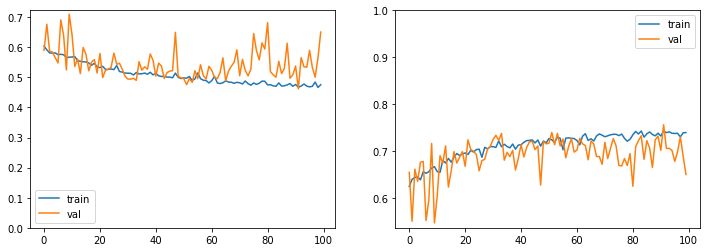

In [26]:
y = np.array([mrk.photo_reqs.frame_covering_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'frame_covering_eyes')
list_model_files.append(model_file)

#### 21. Hat/cap 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6036 - accuracy: 0.5941 - precision: 0.9154 - recall: 0.5770 - f1: 0.6930 - specificity: 0.7225 - negative_predictive_value: 0.2320 - matthews_correlation_coefficient: 0.2086 - val_loss: 0.5636 - val_accuracy: 0.5889 - val_precision: 0.9194 - val_recall: 0.5369 - val_f1: 0.6748 - val_specificity: 0.7872 - val_negative_predictive_value: 0.2285 - val_matthews_correlation_coefficient: 0.2413

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.24131, saving model to ../models/autoencoders_requirements/hat_cap_2020_03_28-23_28_01.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5650 - accuracy: 0.6184 - precision: 0.9447 - recall: 0.5906 - f1: 0.7163 - specificity: 0.7781 - negative_predictive_value: 0.2562 - matthews_correlation_coefficient: 0.2693 - val_loss: 0.5132 - val_accuracy: 0.7051 - val_precision: 0.


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.35684
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4853 - accuracy: 0.7171 - precision: 0.9556 - recall: 0.7070 - f1: 0.8052 - specificity: 0.7914 - negative_predictive_value: 0.3376 - matthews_correlation_coefficient: 0.3759 - val_loss: 0.3926 - val_accuracy: 0.7962 - val_precision: 0.9332 - val_recall: 0.8280 - val_f1: 0.8757 - val_specificity: 0.6213 - val_negative_predictive_value: 0.3540 - val_matthews_correlation_coefficient: 0.3503

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.35684
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4801 - accuracy: 0.7171 - precision: 0.9526 - recall: 0.7038 - f1: 0.8042 - specificity: 0.7793 - negative_predictive_value: 0.3177 - matthews_correlation_coefficient: 0.3568 - val_loss: 0.4958 - val_accuracy: 0.7121 - val_precision: 0.9625 - val_recall: 0.7000 - val_f1: 0.8072 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4384 - accuracy: 0.7525 - precision: 0.9565 - recall: 0.7354 - f1: 0.8274 - specificity: 0.8293 - negative_predictive_value: 0.3653 - matthews_correlation_coefficient: 0.4265 - val_loss: 0.7003 - val_accuracy: 0.5976 - val_precision: 0.9720 - val_recall: 0.5585 - val_f1: 0.7034 - val_specificity: 0.8681 - val_negative_predictive_value: 0.2418 - val_matthews_correlation_coefficient: 0.2948

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.40241
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5292 - accuracy: 0.6685 - precision: 0.9397 - recall: 0.6515 - f1: 0.7526 - specificity: 0.7822 - negative_predictive_value: 0.2934 - matthews_correlation_coefficient: 0.3211 - val_loss: 0.3865 - val_accuracy: 0.7936 - val_precision: 0.9278 - val_recall: 0.8287 - val_f1: 0.8736 - val_specificity: 0.6163 - val_negative_predictive_value: 0.3560 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4187 - accuracy: 0.7521 - precision: 0.9638 - recall: 0.7409 - f1: 0.8316 - specificity: 0.8138 - negative_predictive_value: 0.3631 - matthews_correlation_coefficient: 0.4214 - val_loss: 0.3573 - val_accuracy: 0.8057 - val_precision: 0.9269 - val_recall: 0.8450 - val_f1: 0.8826 - val_specificity: 0.6012 - val_negative_predictive_value: 0.3568 - val_matthews_correlation_coefficient: 0.3481

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.42249
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4215 - accuracy: 0.7636 - precision: 0.9628 - recall: 0.7550 - f1: 0.8415 - specificity: 0.8205 - negative_predictive_value: 0.3736 - matthews_correlation_coefficient: 0.4324 - val_loss: 0.3530 - val_accuracy: 0.8196 - val_precision: 0.9318 - val_recall: 0.8590 - val_f1: 0.8923 - val_specificity: 0.5934 - val_negative_predictive_value: 0.3812 - val_matthews_correlation_coefficie


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.43140
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4019 - accuracy: 0.7651 - precision: 0.9674 - recall: 0.7519 - f1: 0.8424 - specificity: 0.8561 - negative_predictive_value: 0.3740 - matthews_correlation_coefficient: 0.4471 - val_loss: 0.4121 - val_accuracy: 0.7667 - val_precision: 0.9470 - val_recall: 0.7793 - val_f1: 0.8517 - val_specificity: 0.7065 - val_negative_predictive_value: 0.3319 - val_matthews_correlation_coefficient: 0.3595

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.43140
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3999 - accuracy: 0.7657 - precision: 0.9717 - recall: 0.7477 - f1: 0.8396 - specificity: 0.8528 - negative_predictive_value: 0.3808 - matthews_correlation_coefficient: 0.4560 - val_loss: 0.3504 - val_accuracy: 0.8144 - val_precision: 0.9391 - val_recall: 0.8431 - val_f1: 0.8869 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.43140
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3925 - accuracy: 0.7798 - precision: 0.9616 - recall: 0.7730 - f1: 0.8509 - specificity: 0.8186 - negative_predictive_value: 0.3905 - matthews_correlation_coefficient: 0.4514 - val_loss: 0.3429 - val_accuracy: 0.8265 - val_precision: 0.9263 - val_recall: 0.8737 - val_f1: 0.8973 - val_specificity: 0.5851 - val_negative_predictive_value: 0.4023 - val_matthews_correlation_coefficient: 0.3771

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.43140
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4004 - accuracy: 0.7859 - precision: 0.9600 - recall: 0.7736 - f1: 0.8495 - specificity: 0.8178 - negative_predictive_value: 0.4189 - matthews_correlation_coefficient: 0.4681 - val_loss: 0.3831 - val_accuracy: 0.8161 - val_precision: 0.9380 - val_recall: 0.8473 - val_f1: 0.8887 - val_spe

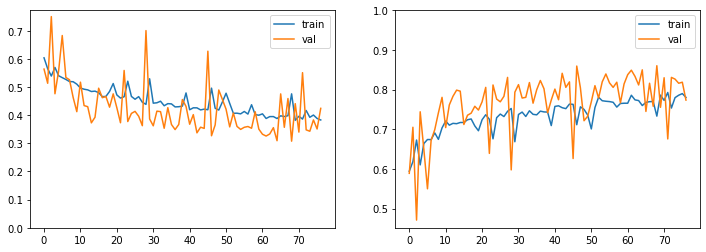

In [27]:
y = np.array([mrk.photo_reqs.hat_cap.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'hat_cap')
list_model_files.append(model_file)

#### *22. Veil Over Face*

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.4151 - accuracy: 0.7818 - precision: 0.9921 - recall: 0.7720 - f1: 0.8622 - specificity: 0.8027 - negative_predictive_value: 0.2278 - matthews_correlation_coefficient: 0.3544 - val_loss: 0.3807 - val_accuracy: 0.8387 - val_precision: 0.9643 - val_recall: 0.8136 - val_f1: 0.8811 - val_specificity: 0.7748 - val_negative_predictive_value: 0.2588 - val_matthews_correlation_coefficient: 0.3829

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.38286, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_28-23_40_04.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3224 - accuracy: 0.8698 - precision: 0.9917 - recall: 0.8666 - f1: 0.9230 - specificity: 0.7196 - negative_predictive_value: 0.3117 - matthews_correlation_coefficient: 0.4179 - val_loss: 0.4039 - val_accuracy: 0.8491 - val_precis


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.53481
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2420 - accuracy: 0.9137 - precision: 0.9932 - recall: 0.9151 - f1: 0.9512 - specificity: 0.8032 - negative_predictive_value: 0.4458 - matthews_correlation_coefficient: 0.5529 - val_loss: 0.1638 - val_accuracy: 0.9402 - val_precision: 0.9635 - val_recall: 0.9206 - val_f1: 0.9412 - val_specificity: 0.7477 - val_negative_predictive_value: 0.4653 - val_matthews_correlation_coefficient: 0.5518

Epoch 00015: val_matthews_correlation_coefficient improved from 0.53481 to 0.55181, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_28-23_40_04.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2521 - accuracy: 0.9111 - precision: 0.9915 - recall: 0.9133 - f1: 0.9495 - specificity: 0.7800 - negative_predictive_value: 0.4183 - matthews_correlation_coefficient: 0.5216 - val_loss: 0.2118

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2013 - accuracy: 0.9367 - precision: 0.9937 - recall: 0.9359 - f1: 0.9627 - specificity: 0.7568 - negative_predictive_value: 0.4992 - matthews_correlation_coefficient: 0.5786 - val_loss: 0.1349 - val_accuracy: 0.9618 - val_precision: 0.9908 - val_recall: 0.9692 - val_f1: 0.9796 - val_specificity: 0.7658 - val_negative_predictive_value: 0.5844 - val_matthews_correlation_coefficient: 0.6389

Epoch 00029: val_matthews_correlation_coefficient improved from 0.59435 to 0.63893, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_28-23_40_04.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2280 - accuracy: 0.9260 - precision: 0.9887 - recall: 0.9293 - f1: 0.9561 - specificity: 0.7759 - negative_predictive_value: 0.4853 - matthews_correlation_coefficient: 0.5692 - val_loss: 0.4017 - val_accuracy: 0.8846 - val_precision: 0.9668 - val_recall: 0.8596 - val_f1: 0.9093 - val_s


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.63893
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1749 - accuracy: 0.9434 - precision: 0.9947 - recall: 0.9450 - f1: 0.9683 - specificity: 0.7918 - negative_predictive_value: 0.5377 - matthews_correlation_coefficient: 0.6144 - val_loss: 0.1421 - val_accuracy: 0.9584 - val_precision: 0.9944 - val_recall: 0.9622 - val_f1: 0.9776 - val_specificity: 0.8063 - val_negative_predictive_value: 0.5943 - val_matthews_correlation_coefficient: 0.6614

Epoch 00044: val_matthews_correlation_coefficient improved from 0.63893 to 0.66135, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_28-23_40_04.h5
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1669 - accuracy: 0.9525 - precision: 0.9940 - recall: 0.9554 - f1: 0.9738 - specificity: 0.8133 - negative_predictive_value: 0.5938 - matthews_correlation_coefficient: 0.6608 - val_loss: 0.3109

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1426 - accuracy: 0.9553 - precision: 0.9956 - recall: 0.9573 - f1: 0.9754 - specificity: 0.7998 - negative_predictive_value: 0.6052 - matthews_correlation_coefficient: 0.6648 - val_loss: 0.2973 - val_accuracy: 0.9011 - val_precision: 0.9700 - val_recall: 0.8740 - val_f1: 0.9189 - val_specificity: 0.8333 - val_negative_predictive_value: 0.3627 - val_matthews_correlation_coefficient: 0.5044

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.71557
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1717 - accuracy: 0.9453 - precision: 0.9949 - recall: 0.9469 - f1: 0.9688 - specificity: 0.8375 - negative_predictive_value: 0.5878 - matthews_correlation_coefficient: 0.6648 - val_loss: 0.3690 - val_accuracy: 0.8751 - val_precision: 0.9678 - val_recall: 0.8489 - val_f1: 0.9038 - val_specificity: 0.8198 - val_negative_predictive_value: 0.3081 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1350 - accuracy: 0.9618 - precision: 0.9960 - recall: 0.9637 - f1: 0.9791 - specificity: 0.8340 - negative_predictive_value: 0.6286 - matthews_correlation_coefficient: 0.6933 - val_loss: 0.2723 - val_accuracy: 0.8673 - val_precision: 0.9698 - val_recall: 0.8383 - val_f1: 0.8985 - val_specificity: 0.8333 - val_negative_predictive_value: 0.2974 - val_matthews_correlation_coefficient: 0.4485

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.71557
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1272 - accuracy: 0.9547 - precision: 0.9962 - recall: 0.9558 - f1: 0.9748 - specificity: 0.8389 - negative_predictive_value: 0.6110 - matthews_correlation_coefficient: 0.6828 - val_loss: 0.1687 - val_accuracy: 0.9237 - val_precision: 0.9959 - val_recall: 0.9239 - val_f1: 0.9581 - val_specificity: 0.8279 - val_negative_predictive_value: 0.4172 - val_matthews_correlation_coefficie

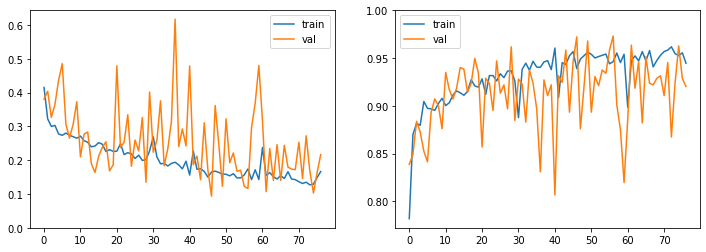

In [28]:
y = np.array([mrk.photo_reqs.veil_over_face.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'veil_over_face')
list_model_files.append(model_file)

#### 23. Mouth Open 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6123 - accuracy: 0.6430 - precision: 0.8694 - recall: 0.6033 - f1: 0.7009 - specificity: 0.7477 - negative_predictive_value: 0.4076 - matthews_correlation_coefficient: 0.3106 - val_loss: 0.6753 - val_accuracy: 0.6288 - val_precision: 0.8530 - val_recall: 0.5598 - val_f1: 0.6707 - val_specificity: 0.7804 - val_negative_predictive_value: 0.4181 - val_matthews_correlation_coefficient: 0.3027

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.30268, saving model to ../models/autoencoders_requirements/mouth_open_2020_03_28-23_51_46.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5787 - accuracy: 0.6824 - precision: 0.8755 - recall: 0.6548 - f1: 0.7390 - specificity: 0.7567 - negative_predictive_value: 0.4584 - matthews_correlation_coefficient: 0.3678 - val_loss: 0.7192 - val_accuracy: 0.6071 - val_precision:


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.35718
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5520 - accuracy: 0.6824 - precision: 0.8968 - recall: 0.6485 - f1: 0.7448 - specificity: 0.7951 - negative_predictive_value: 0.4543 - matthews_correlation_coefficient: 0.3930 - val_loss: 0.5925 - val_accuracy: 0.6626 - val_precision: 0.8670 - val_recall: 0.6014 - val_f1: 0.7062 - val_specificity: 0.7978 - val_negative_predictive_value: 0.4435 - val_matthews_correlation_coefficient: 0.3506

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.35718
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5371 - accuracy: 0.6998 - precision: 0.8990 - recall: 0.6687 - f1: 0.7615 - specificity: 0.7887 - negative_predictive_value: 0.4636 - matthews_correlation_coefficient: 0.4062 - val_loss: 0.5682 - val_accuracy: 0.6678 - val_precision: 0.8671 - val_recall: 0.6093 - val_f1: 0.7117 - val_spe


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.36334
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5238 - accuracy: 0.7132 - precision: 0.9049 - recall: 0.6833 - f1: 0.7731 - specificity: 0.7885 - negative_predictive_value: 0.4754 - matthews_correlation_coefficient: 0.4233 - val_loss: 0.5717 - val_accuracy: 0.6869 - val_precision: 0.8536 - val_recall: 0.6491 - val_f1: 0.7334 - val_specificity: 0.7517 - val_negative_predictive_value: 0.4623 - val_matthews_correlation_coefficient: 0.3543

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.36334
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5184 - accuracy: 0.7236 - precision: 0.9019 - recall: 0.7066 - f1: 0.7870 - specificity: 0.7934 - negative_predictive_value: 0.4951 - matthews_correlation_coefficient: 0.4430 - val_loss: 0.6967 - val_accuracy: 0.6245 - val_precision: 0.8769 - val_recall: 0.5346 - val_f1: 0.6597 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5084 - accuracy: 0.7223 - precision: 0.9004 - recall: 0.6919 - f1: 0.7776 - specificity: 0.7970 - negative_predictive_value: 0.4925 - matthews_correlation_coefficient: 0.4363 - val_loss: 0.5995 - val_accuracy: 0.6583 - val_precision: 0.8791 - val_recall: 0.5848 - val_f1: 0.6978 - val_specificity: 0.8228 - val_negative_predictive_value: 0.4416 - val_matthews_correlation_coefficient: 0.3600

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.38214
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5185 - accuracy: 0.7174 - precision: 0.9105 - recall: 0.6854 - f1: 0.7738 - specificity: 0.8009 - negative_predictive_value: 0.4846 - matthews_correlation_coefficient: 0.4375 - val_loss: 0.5621 - val_accuracy: 0.6808 - val_precision: 0.8583 - val_recall: 0.6364 - val_f1: 0.7268 - val_specificity: 0.7647 - val_negative_predictive_value: 0.4583 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5044 - accuracy: 0.7289 - precision: 0.9018 - recall: 0.7009 - f1: 0.7829 - specificity: 0.8008 - negative_predictive_value: 0.4968 - matthews_correlation_coefficient: 0.4457 - val_loss: 0.5589 - val_accuracy: 0.6765 - val_precision: 0.8716 - val_recall: 0.6173 - val_f1: 0.7185 - val_specificity: 0.7976 - val_negative_predictive_value: 0.4552 - val_matthews_correlation_coefficient: 0.3667

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.38214
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4932 - accuracy: 0.7338 - precision: 0.9124 - recall: 0.7053 - f1: 0.7899 - specificity: 0.8014 - negative_predictive_value: 0.4982 - matthews_correlation_coefficient: 0.4563 - val_loss: 0.5257 - val_accuracy: 0.6973 - val_precision: 0.8713 - val_recall: 0.6497 - val_f1: 0.7398 - val_specificity: 0.7871 - val_negative_predictive_value: 0.4737 - val_matthews_correlation_coefficie


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.38675
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4934 - accuracy: 0.7343 - precision: 0.9040 - recall: 0.7043 - f1: 0.7861 - specificity: 0.8034 - negative_predictive_value: 0.5003 - matthews_correlation_coefficient: 0.4522 - val_loss: 0.5676 - val_accuracy: 0.6860 - val_precision: 0.8700 - val_recall: 0.6317 - val_f1: 0.7285 - val_specificity: 0.7937 - val_negative_predictive_value: 0.4616 - val_matthews_correlation_coefficient: 0.3741

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.38675
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4861 - accuracy: 0.7338 - precision: 0.9102 - recall: 0.7081 - f1: 0.7915 - specificity: 0.8092 - negative_predictive_value: 0.4972 - matthews_correlation_coefficient: 0.4592 - val_loss: 0.5005 - val_accuracy: 0.7199 - val_precision: 0.8503 - val_recall: 0.7053 - val_f1: 0.7679 - val_spe


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.39347
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4812 - accuracy: 0.7386 - precision: 0.9185 - recall: 0.7076 - f1: 0.7942 - specificity: 0.8123 - negative_predictive_value: 0.5031 - matthews_correlation_coefficient: 0.4670 - val_loss: 0.5793 - val_accuracy: 0.6904 - val_precision: 0.8471 - val_recall: 0.6603 - val_f1: 0.7380 - val_specificity: 0.7357 - val_negative_predictive_value: 0.4650 - val_matthews_correlation_coefficient: 0.3499

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.39347
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4758 - accuracy: 0.7484 - precision: 0.9109 - recall: 0.7186 - f1: 0.7983 - specificity: 0.8149 - negative_predictive_value: 0.5209 - matthews_correlation_coefficient: 0.4803 - val_loss: 0.5205 - val_accuracy: 0.7095 - val_precision: 0.8647 - val_recall: 0.6746 - val_f1: 0.7542 - val_spe

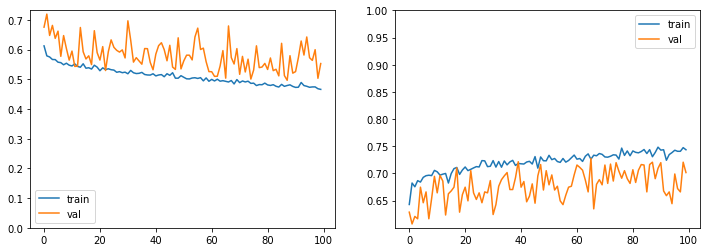

In [29]:
y = np.array([mrk.photo_reqs.mouth_open.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'mouth_open')
list_model_files.append(model_file)

#### *24. Presence of Other Faces or Toys too Close to Face*

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.4236 - accuracy: 0.7872 - precision: 0.9977 - recall: 0.7844 - f1: 0.8690 - specificity: 0.2931 - negative_predictive_value: 0.0630 - matthews_correlation_coefficient: 0.1129 - val_loss: 0.7832 - val_accuracy: 0.6652 - val_precision: 0.9987 - val_recall: 0.6708 - val_f1: 0.7989 - val_specificity: 0.2703 - val_negative_predictive_value: 0.0302 - val_matthews_correlation_coefficient: 0.0683

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.06832, saving model to ../models/autoencoders_requirements/presence_of_other_faces_or_toys_2020_03_29-00_07_13.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3391 - accuracy: 0.8362 - precision: 0.9987 - recall: 0.8362 - f1: 0.9080 - specificity: 0.2920 - negative_predictive_value: 0.0586 - matthews_correlation_coefficient: 0.1138 - val_loss: 0.1883 - val_accuracy: 0.

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2897 - accuracy: 0.8393 - precision: 0.9987 - recall: 0.8396 - f1: 0.9111 - specificity: 0.2908 - negative_predictive_value: 0.0672 - matthews_correlation_coefficient: 0.1241 - val_loss: 0.4747 - val_accuracy: 0.7901 - val_precision: 1.0000 - val_recall: 0.7928 - val_f1: 0.8825 - val_specificity: 0.2973 - val_negative_predictive_value: 0.0459 - val_matthews_correlation_coefficient: 0.1010

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.13140
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3081 - accuracy: 0.8304 - precision: 0.9995 - recall: 0.8301 - f1: 0.9038 - specificity: 0.3207 - negative_predictive_value: 0.0776 - matthews_correlation_coefficient: 0.1404 - val_loss: 0.2640 - val_accuracy: 0.8630 - val_precision: 0.9989 - val_recall: 0.8656 - val_f1: 0.9265 - val_specificity: 0.2703 - val_negative_predictive_value: 0.0644 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.13868
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2697 - accuracy: 0.8525 - precision: 0.9990 - recall: 0.8523 - f1: 0.9179 - specificity: 0.3138 - negative_predictive_value: 0.0748 - matthews_correlation_coefficient: 0.1347 - val_loss: 0.2798 - val_accuracy: 0.8482 - val_precision: 1.0000 - val_recall: 0.8501 - val_f1: 0.9174 - val_specificity: 0.2973 - val_negative_predictive_value: 0.0623 - val_matthews_correlation_coefficient: 0.1183

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.13868
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2681 - accuracy: 0.8466 - precision: 0.9994 - recall: 0.8463 - f1: 0.9150 - specificity: 0.3034 - negative_predictive_value: 0.0783 - matthews_correlation_coefficient: 0.1401 - val_loss: 0.1979 - val_accuracy: 0.8985 - val_precision: 0.9990 - val_recall: 0.9009 - val_f1: 0.9467 - val_spe


Epoch 00044: val_matthews_correlation_coefficient improved from 0.14578 to 0.15000, saving model to ../models/autoencoders_requirements/presence_of_other_faces_or_toys_2020_03_29-00_07_13.h5
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2244 - accuracy: 0.8751 - precision: 0.9995 - recall: 0.8750 - f1: 0.9322 - specificity: 0.3345 - negative_predictive_value: 0.0993 - matthews_correlation_coefficient: 0.1667 - val_loss: 0.2491 - val_accuracy: 0.8751 - val_precision: 1.0000 - val_recall: 0.8767 - val_f1: 0.9332 - val_specificity: 0.2973 - val_negative_predictive_value: 0.0737 - val_matthews_correlation_coefficient: 0.1328

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.15000
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2216 - accuracy: 0.8709 - precision: 0.9995 - recall: 0.8708 - f1: 0.9297 - specificity: 0.3172 - negative_predictive_value: 0.0903 - matthews_correlation_coefficient: 0.1542 -

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2419 - accuracy: 0.8731 - precision: 0.9995 - recall: 0.8729 - f1: 0.9302 - specificity: 0.3034 - negative_predictive_value: 0.1012 - matthews_correlation_coefficient: 0.1571 - val_loss: 0.3341 - val_accuracy: 0.8404 - val_precision: 1.0000 - val_recall: 0.8425 - val_f1: 0.9133 - val_specificity: 0.2973 - val_negative_predictive_value: 0.0600 - val_matthews_correlation_coefficient: 0.1192

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.15098
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2022 - accuracy: 0.8866 - precision: 0.9995 - recall: 0.8862 - f1: 0.9385 - specificity: 0.3069 - negative_predictive_value: 0.0846 - matthews_correlation_coefficient: 0.1472 - val_loss: 0.3050 - val_accuracy: 0.8873 - val_precision: 1.0000 - val_recall: 0.8888 - val_f1: 0.9402 - val_specificity: 0.2973 - val_negative_predictive_value: 0.0821 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2309 - accuracy: 0.8818 - precision: 0.9995 - recall: 0.8817 - f1: 0.9360 - specificity: 0.3103 - negative_predictive_value: 0.1089 - matthews_correlation_coefficient: 0.1657 - val_loss: 0.3521 - val_accuracy: 0.8690 - val_precision: 1.0000 - val_recall: 0.8707 - val_f1: 0.9295 - val_specificity: 0.2973 - val_negative_predictive_value: 0.0728 - val_matthews_correlation_coefficient: 0.1315

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.16957
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2004 - accuracy: 0.8779 - precision: 0.9995 - recall: 0.8744 - f1: 0.9315 - specificity: 0.3011 - negative_predictive_value: 0.0866 - matthews_correlation_coefficient: 0.1464 - val_loss: 0.1699 - val_accuracy: 0.9159 - val_precision: 1.0000 - val_recall: 0.9172 - val_f1: 0.9561 - val_specificity: 0.2973 - val_negative_predictive_value: 0.1194 - val_matthews_correlation_coefficie


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.17490
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1838 - accuracy: 0.8954 - precision: 0.9998 - recall: 0.8950 - f1: 0.9437 - specificity: 0.3034 - negative_predictive_value: 0.0906 - matthews_correlation_coefficient: 0.1535 - val_loss: 0.2548 - val_accuracy: 0.8846 - val_precision: 1.0000 - val_recall: 0.8863 - val_f1: 0.9387 - val_specificity: 0.2973 - val_negative_predictive_value: 0.0905 - val_matthews_correlation_coefficient: 0.1489

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.17490
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1810 - accuracy: 0.8957 - precision: 0.9998 - recall: 0.8954 - f1: 0.9440 - specificity: 0.2862 - negative_predictive_value: 0.1028 - matthews_correlation_coefficient: 0.1585 - val_loss: 0.2035 - val_accuracy: 0.8968 - val_precision: 1.0000 - val_recall: 0.8981 - val_f1: 0.9454 - val_spe

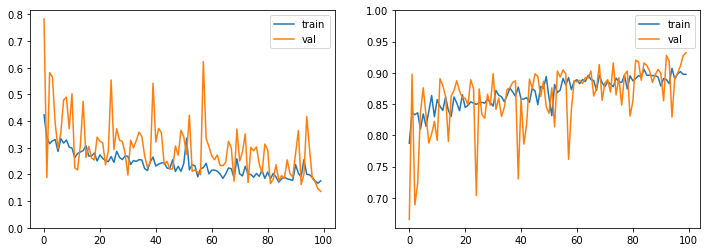

In [30]:
y = np.array([mrk.photo_reqs.presence_of_other_faces_or_toys.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'presence_of_other_faces_or_toys')
list_model_files.append(model_file)

# Models Merge

In [31]:
def add_requirement_branch_to_base_model(base_model_last_layer, req_model):
    req_layers = [layer for layer in req_model.layers if isinstance(layer, Dense)]

    outputs = base_model_last_layer
    for layer in req_layers:
        outputs = req_model.get_layer(layer.name)(outputs)

    return outputs

In [32]:
file_models = np.array([file for file in list_model_files if file is not None])

print(file_models)

['../models/autoencoders_requirements/blurred_2020_03_28-19_26_00.h5'
 '../models/autoencoders_requirements/looking_away_2020_03_28-19_40_52.h5'
 '../models/autoencoders_requirements/unnatural_skin_tone_2020_03_28-19_50_23.h5'
 '../models/autoencoders_requirements/too_dark_light_2020_03_28-20_05_06.h5'
 '../models/autoencoders_requirements/washed_out_2020_03_28-20_12_26.h5'
 '../models/autoencoders_requirements/pixelation_2020_03_28-20_23_54.h5'
 '../models/autoencoders_requirements/hair_across_eyes_2020_03_28-20_34_46.h5'
 '../models/autoencoders_requirements/eyes_closed_2020_03_28-20_49_34.h5'
 '../models/autoencoders_requirements/varied_background_2020_03_28-21_07_01.h5'
 '../models/autoencoders_requirements/roll_pitch_yaw_2020_03_28-21_21_49.h5'
 '../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_28-21_37_40.h5'
 '../models/autoencoders_requirements/red_eyes_2020_03_28-21_53_42.h5'
 '../models/autoencoders_requirements/shadows_behind_head_2020_03_28-22_08_33.h5'


In [33]:
autoencoder = load_model(FILE_BASE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(autoencoder.get_layer(name='encoded').output)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


In [34]:
custom_objects = {
    'recall': recall,
    'precision': precision,
    'f1': f1,
    'specificity': specificity,
    'negative_predictive_value': npv,
    'matthews_correlation_coefficient': mcc
}

list_models = [load_model(file, custom_objects=custom_objects) for file in file_models]
list_outputs = [add_requirement_branch_to_base_model(embeddings, model) for model in list_models]

In [35]:
merged_model = Model(inputs=autoencoder.inputs, outputs=list_outputs)
merged_model.summary()

merged_model.save(FILE_MERGED_MODEL)

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 224, 224, 16) 448         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 224, 224, 16) 64          conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 224, 224, 16) 0           bn_1[0][0]                       
___________________________________________________________________________________________

In [36]:
import cv2
from glob import glob

# list_files = glob('../data/pybossa/images/*')
list_files = ['../data/pybossa/images/AR_FDB_m-013-17.png']
random_file = np.random.choice(list_files)
print(random_file)

im = load.images_from_list_files([random_file], output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

y_pred = merged_model.predict(im)
list_predictions = [model.predict(im) for model in list_models]
assert(np.all([np.allclose(pred1, pred2) for pred1, pred2 in zip(y_pred, list_predictions)]))

y_pred

../data/pybossa/images/AR_FDB_m-013-17.png
1 of 1


[array([[0.9999937]], dtype=float32),
 array([[0.6946744]], dtype=float32),
 array([[0.9927361]], dtype=float32),
 array([[0.97761565]], dtype=float32),
 array([[0.999747]], dtype=float32),
 array([[0.98056316]], dtype=float32),
 array([[0.69546473]], dtype=float32),
 array([[0.5190913]], dtype=float32),
 array([[0.5775314]], dtype=float32),
 array([[0.8948274]], dtype=float32),
 array([[0.8384881]], dtype=float32),
 array([[0.44822827]], dtype=float32),
 array([[0.99960166]], dtype=float32),
 array([[0.986477]], dtype=float32),
 array([[0.9586261]], dtype=float32),
 array([[0.6006178]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.5487069]], dtype=float32),
 array([[0.9999708]], dtype=float32),
 array([[0.9973628]], dtype=float32),
 array([[0.43765327]], dtype=float32),
 array([[1.]], dtype=float32)]